In [2]:
import numpy as np
import scipy as sp
import sympy as smp
import matplotlib.pyplot as plt
import pandas as pd #Lo necesito para cargar y leer el csv

import os
import random
import time
from datetime import datetime

import tensorflow
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential #

# **Modelo cinemático del robot IRB 140**

Modelo cinemático del robot IRB 140 para determinar si los puntos que serán generados de forma random son válidos: el robot puede llegar a esa posición de forma cartesiana sin cambiar la configuración en el trayecto.


**Robot sin hombro:** los ejes 1, 4 y 6 son coplanares (estan en el mismo plano).


Por la definición de ternas utilizadas (longitudes en mm)

| EJE | D      | THETA   | ALPHA  | A      |
| :-- | ------ | ------- | ------ | ------ |
| 1   | d1=352 | q1      | -90    | a1=70  |
| 2   | 0      | q2-90   | 0      | a2=360 |
| 3   | 0      | q3      | -90    | 0      |
| 4   | d4=380 | q4      | 90     | 0      |
| 5   | 0      | q5      | -90    | 0      |
| 6   | d6=65  | q6-180  | 0      | 0      |


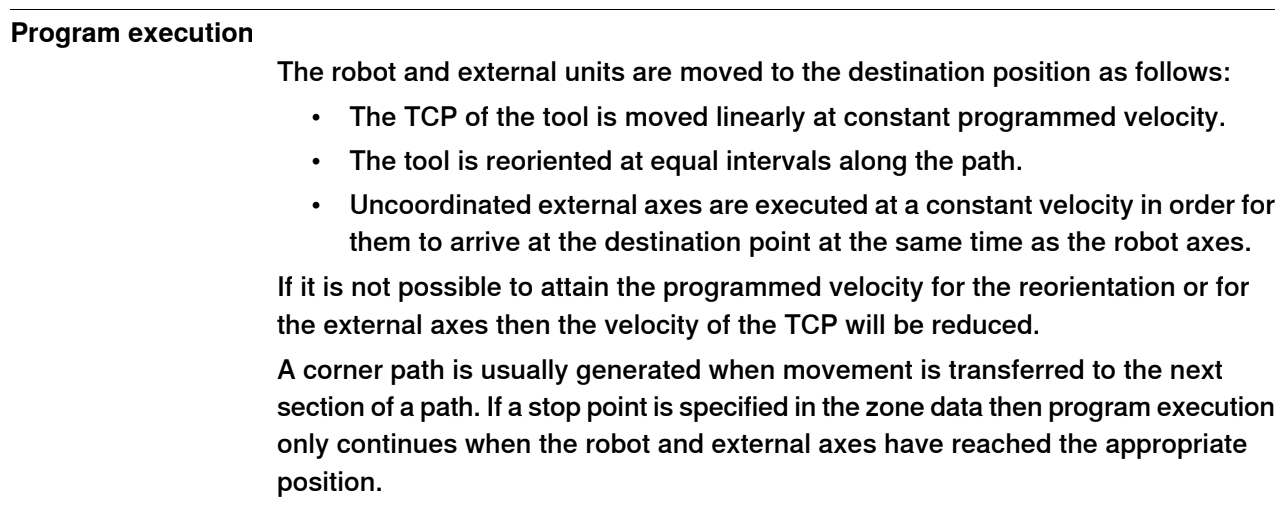

In [3]:
#Parametros DH del IRB140 Verificando segun robotstudio
a_irb140 = np.array([70, 360., 0, 0., 0, 0])
d_irb140 = np.array([352., 0, 0, 380, 0, 0])

#a_irb140 = np.array([70, 360., 0, 0., 0, 0])
#d_irb140 = np.array([0, 0, 0, 732, 0, -65])
alpha_irb140 = np.array([-1, 0, -1, 1, -1, 0]) * np.pi / 2.


# theta_irb140_real = theta_irb140 + thetas_correction
thetas_correction = np.array([0, -90, 0, 0, 0, -180]) * (np.pi/180)
theta_irb140 = np.array([52.8, -2, 10, 13, 56, 28]) * (np.pi/180) #Estos thetas son para probar

In [4]:
theta = smp.symbols('theta1:{0}'.format(7), real=True)
a = smp.symbols('a1:{0}'.format(7), real=True)
d = smp.symbols('d1:{0}'.format(7), real=True)
alpha = smp.symbols('alpha1:{0}'.format(7), real=True)

In [5]:
#Problema cinemático directo
def symbolic_irb140_forward_kinematics():
  J = []
  for i in range(6):
      # Use symbolic expressions for DH parameters
      A_i = smp.Matrix([
          [smp.cos(theta[i]), -smp.sin(theta[i]) * smp.cos(alpha[i]), smp.sin(theta[i]) * smp.sin(alpha[i]), a[i] * smp.cos(theta[i])],
          [smp.sin(theta[i]), smp.cos(theta[i]) * smp.cos(alpha[i]), -smp.cos(theta[i]) * smp.sin(alpha[i]), a[i] * smp.sin(theta[i])],
          [0.0, smp.sin(alpha[i]), smp.cos(alpha[i]), d[i]],
          [0.0, 0.0, 0.0, 1.0]
      ])
      J.append(A_i)
      J[i] = smp.simplify(J[i])

  A_0_n = J[0]
  for matrix in range(5):
    A_0_n = A_0_n * J[matrix+1]

  #A_0_n
  J.append(A_0_n)
  return J

In [6]:
def irb140_forward_kinematics(J, thetas):
    sym_expressions = [
      [expr for expr in row] for row in J
    ]

    lambdified_expr = np.array([
          [smp.lambdify((a, d, alpha, theta), expr, 'numpy') for expr in J[i]]
          for i in range(6+1)
      ])

    matrices = []
    for row in lambdified_expr:
        T = np.block([expr(a_irb140, d_irb140, alpha_irb140, thetas) for expr in row])
        matrices.append(T)
    replaced_matrixes = np.array(matrices)
    replaced_matrixes = np.asarray(replaced_matrixes).reshape(replaced_matrixes.shape[0], 4, 4)
    return replaced_matrixes

In [7]:
J_sym = symbolic_irb140_forward_kinematics()
J_matrix = irb140_forward_kinematics(J_sym, theta_irb140+thetas_correction)
J_06 = irb140_forward_kinematics(J_sym, theta_irb140+thetas_correction)[-1,0:3,3]
J_06#Funciona con la verificación ya que para el theta de prueba me da lo mismo q en robotstudio array([269.92581072, 375.66383285, 601.84099693])

array([262.23763949, 345.48533127, 658.89491936])

In [8]:
#print(smp.latex(J_sym[6]))
symbolic_constants = {
    smp.symbols('alpha1', real=True): alpha_irb140[0],
    smp.symbols('alpha2', real=True): alpha_irb140[1],
    smp.symbols('alpha3', real=True): alpha_irb140[2],
    smp.symbols('alpha4', real=True): alpha_irb140[3],
    smp.symbols('alpha5', real=True): alpha_irb140[4],
    smp.symbols('alpha6', real=True): alpha_irb140[5],
    smp.symbols('a3', real=True): a_irb140[2],
    smp.symbols('a4', real=True): a_irb140[3],
    smp.symbols('a5', real=True): a_irb140[4],
    smp.symbols('a6', real=True): a_irb140[5],
    smp.symbols('d2', real=True): d_irb140[1],
    smp.symbols('d3', real=True): d_irb140[2],
    smp.symbols('d5', real=True): d_irb140[4],
    smp.symbols('d6', real=True): d_irb140[5],
    smp.symbols('theta2', real=True): smp.symbols('theta2', real=True) - (90 * smp.pi/180),
}

# Realizar las sustituciones en la expresión simbólica
J_sym_substituted = [expr.subs(symbolic_constants) for expr in J_sym[6]]
J_sym_substituted = [expr.rewrite(smp.sin, smp.cos) for expr in J_sym_substituted]
J_sym_substituted = [smp.nsimplify(expr, tolerance=1e-10) for expr in J_sym_substituted]


J_sym_substituted[0]

(((cos(theta1)*cos(theta2)*cos(theta3 - pi/2) + cos(theta1)*cos(theta3)*cos(theta2 - pi/2))*cos(theta4) + cos(theta1 - pi/2)*cos(theta4 - pi/2))*cos(theta5) + (cos(theta1)*cos(theta2)*cos(theta3) - cos(theta1)*cos(theta2 - pi/2)*cos(theta3 - pi/2))*cos(theta5 - pi/2))*cos(theta6) + (-(cos(theta1)*cos(theta2)*cos(theta3 - pi/2) + cos(theta1)*cos(theta3)*cos(theta2 - pi/2))*cos(theta4 - pi/2) + cos(theta4)*cos(theta1 - pi/2))*cos(theta6 - pi/2)

In [9]:
smp.trigsimp(J_sym_substituted[3])

(a1 + a2*sin(theta2) + d4*cos(theta2 + theta3))*cos(theta1)

In [10]:
J_sym[0]

Matrix([
[cos(theta1), -sin(theta1)*cos(alpha1),  sin(alpha1)*sin(theta1), a1*cos(theta1)],
[sin(theta1),  cos(alpha1)*cos(theta1), -sin(alpha1)*cos(theta1), a1*sin(theta1)],
[        0.0,              sin(alpha1),              cos(alpha1),             d1],
[        0.0,                      0.0,                      0.0,            1.0]])

In [11]:
px_s = smp.symbols('px', real=True)
py_s = smp.symbols('py', real=True)
pz_s = smp.symbols('pz', real=True)

point_matrix = smp.Matrix(4,1,[px_s, py_s, pz_s, 1])

point_matrix

Matrix([
[px],
[py],
[pz],
[ 1]])

In [12]:
J_01_sym_substituted = [expr.subs(symbolic_constants) for expr in J_sym[0]]
J_01_sym_substituted = [expr.rewrite(smp.sin, smp.cos) for expr in J_01_sym_substituted]
J_01_sym_substituted = [smp.nsimplify(expr, tolerance=1e-10) for expr in J_01_sym_substituted]
J_01_sym_substituted = [smp.trigsimp(expr) for expr in J_01_sym_substituted]
J_01_sym_substituted =  smp.Matrix(4, 4, J_01_sym_substituted)
smp.trigsimp(J_01_sym_substituted.inv()*point_matrix)

Matrix([
[                                                                                                      -a1 + px*cos(theta1) + py*sin(theta1)],
[d1 - 612323399573677*px*sin(theta1)/10000000000000000000000000000000 + 612323399573677*py*cos(theta1)/10000000000000000000000000000000 - pz],
[                                                                                                           -px*sin(theta1) + py*cos(theta1)],
[                                                                                                                                          1]])

In [13]:
J_12_sym_substituted = [expr.subs(symbolic_constants) for expr in J_sym[1]]
J_12_sym_substituted = [expr.rewrite(smp.sin, smp.cos) for expr in J_12_sym_substituted]
J_12_sym_substituted = [smp.nsimplify(expr, tolerance=1e-10) for expr in J_12_sym_substituted]
J_12_sym_substituted = [smp.trigsimp(expr) for expr in J_12_sym_substituted]
J_12_sym_substituted =  smp.Matrix(4, 4, J_12_sym_substituted)
J_12_sym_substituted

Matrix([
[ sin(theta2), cos(theta2), 0,  a2*sin(theta2)],
[-cos(theta2), sin(theta2), 0, -a2*cos(theta2)],
[           0,           0, 1,               0],
[           0,           0, 0,               1]])

In [14]:
J_23_sym_substituted = [expr.subs(symbolic_constants) for expr in J_sym[2]]
J_23_sym_substituted = [expr.rewrite(smp.sin, smp.cos) for expr in J_23_sym_substituted]
J_23_sym_substituted = [smp.nsimplify(expr, tolerance=1e-10) for expr in J_23_sym_substituted]
J_23_sym_substituted = [smp.trigsimp(expr) for expr in J_23_sym_substituted]
J_23_sym_substituted =  smp.Matrix(4, 4, J_23_sym_substituted)
J_23_sym_substituted

Matrix([
[cos(theta3),  0,                                     -sin(theta3), 0],
[sin(theta3),  0,                                      cos(theta3), 0],
[          0, -1, 612323399573677/10000000000000000000000000000000, 0],
[          0,  0,                                                0, 1]])

In [15]:
J_34_sym_substituted = [expr.subs(symbolic_constants) for expr in J_sym[3]]
J_34_sym_substituted = [expr.rewrite(smp.sin, smp.cos) for expr in J_34_sym_substituted]
J_34_sym_substituted = [smp.nsimplify(expr, tolerance=1e-10) for expr in J_34_sym_substituted]
J_34_sym_substituted = [smp.trigsimp(expr) for expr in J_34_sym_substituted]
J_34_sym_substituted =  smp.Matrix(4, 4, J_34_sym_substituted)
J_34_sym_substituted[:,3]

Matrix([
[ 0],
[ 0],
[d4],
[ 1]])

In [16]:
J_12_sym_substituted*J_23_sym_substituted*J_34_sym_substituted[:,3]
#smp.trigsimp(J_12_sym_substituted*J_23_sym_substituted*J_34_sym_substituted[:,3])

Matrix([
[a2*sin(theta2) + d4*(-sin(theta2)*sin(theta3) + cos(theta2)*cos(theta3))],
[-a2*cos(theta2) + d4*(sin(theta2)*cos(theta3) + sin(theta3)*cos(theta2))],
[                     612323399573677*d4/10000000000000000000000000000000],
[                                                                       1]])

In [17]:
def irb140_inverse_kinematics_arm(point):
  px = point[0]
  py = point[1]
  pz = point[2]

  q1 = np.arctan2((py/(np.sqrt(px**2+py**2)**2)),(px/(np.sqrt(px**2+py**2)**2)))#q1 = q1 * 180/np.pi #Para devolver en grados
  c1 = np.cos(q1) #los cosenos y senos van en radianes
  s1 = np.sin(q1)

  s3 = ((px*c1+py*s1-a_irb140[0])**2 + (d_irb140[0]-pz)**2 - (d_irb140[3]**2+a_irb140[1]**2)) / (2*a_irb140[1]*d_irb140[3])
  q3 = np.arctan2(-s3,np.sqrt(1-s3**2)) #+ np.pi
  c3 = np.cos(q3)

  c2 = ((px*c1+py*s1-a_irb140[0])*(c3*d_irb140[3])-(d_irb140[0]-pz)*(a_irb140[1]+s3*d_irb140[3])) / ((a_irb140[1]+s3*d_irb140[3])**2+(c3*d_irb140[3])**2)
  s2 = ((px*c1+py*s1-a_irb140[0])*(a_irb140[1]+s3*d_irb140[3])+(d_irb140[0]-pz)*(c3*d_irb140[3])) / ((a_irb140[1]+s3*d_irb140[3])**2+(c3*d_irb140[3])**2)
  q2 = np.arctan2(s2,c2)

  return np.array([q1, q2, q3])

In [18]:
#Reescribir porque
def irb140_inverse_kinematics(J_):
  J_0_6 = J_[-1,0:3,3]
  px = J_0_6[0]
  py = J_0_6[1]
  pz = J_0_6[2]

  q1 = np.arctan2((py/(np.sqrt(px**2+py**2)**2)),(px/(np.sqrt(px**2+py**2)**2)))#q1 = q1 * 180/np.pi #Para devolver en grados
  c1 = np.cos(q1) #los cosenos y senos van en radianes
  s1 = np.sin(q1)

  s3 = ((px*c1+py*s1-a_irb140[0])**2 + (d_irb140[0]-pz)**2 - (d_irb140[3]**2+a_irb140[1]**2)) / (2*a_irb140[1]*d_irb140[3])
  q3 = np.arctan2(-s3,np.sqrt(1-s3**2)) #+ np.pi
  c3 = np.cos(q3)

  c2 = ((px*c1+py*s1-a_irb140[0])*(c3*d_irb140[3])-(d_irb140[0]-pz)*(a_irb140[1]+s3*d_irb140[3])) / ((a_irb140[1]+s3*d_irb140[3])**2+(c3*d_irb140[3])**2)
  s2 = ((px*c1+py*s1-a_irb140[0])*(a_irb140[1]+s3*d_irb140[3])+(d_irb140[0]-pz)*(c3*d_irb140[3])) / ((a_irb140[1]+s3*d_irb140[3])**2+(c3*d_irb140[3])**2)
  q2 = np.arctan2(s2,c2) #+ np.pi/2

  #Lo que queda despejar es la rototraslacion R_3_6(q4, q5, q6)
  #R_01 = J_[0,0:3,0:3]
  #R_12 = J_[1,0:3,0:3]
  #R_23 = J_[2,0:3,0:3]
  R_34 = J_[3,0:3,0:3]
  R_45 = J_[4,0:3,0:3]
  R_56 = J_[5,0:3,0:3]
  #R_06 = J_[6,0:3,0:3]

  R_36 = np.dot(np.dot(R_34,R_45),R_56)

  n_z_apos = R_36[2,0]
  s_z_apos = R_36[2,1]
  a_x_apos = R_36[0,2]
  a_y_apos = R_36[1,2]
  a_z_apos = R_36[2,2]

  q5 = np.arctan2(np.sqrt(1-a_z_apos**2),a_z_apos)
  s5 = np.sin(q5)

  q4 = np.arctan2(-a_y_apos/s5,-a_x_apos/s5)
  q6 = np.arctan2(s_z_apos/s5,-n_z_apos/s5)

  thetas = np.array([q1, q2, q3, q4, q5, q6])
  return thetas

In [19]:
#np.array([52.8, -2, 10, 13, 56, 28])
(irb140_inverse_kinematics(J_matrix)) * 180/np.pi

array([52.8, -2. , 10. , 13. , 56. , 28. ])

In [20]:
(irb140_inverse_kinematics_arm(J_matrix[-1,0:3,3])) * 180/np.pi

array([52.8, -2. , 10. ])

In [21]:
def define_line_3d(point_1, point_2):
    # Encontrar el vector director de la línea
    direction = point_2 - point_1
    distance = np.sqrt((point_2[0] - point_1[0])**2 + (point_2[1] - point_1[1])**2 + (point_2[2] - point_1[2])**2)

    # Crear puntos a lo largo de la línea
    t = np.linspace(0, 1, 1000)
    line_points = np.array([point_1 + t_val * direction for t_val in t])
    return line_points

# **Creación de Archivo de Poses IRB-140**

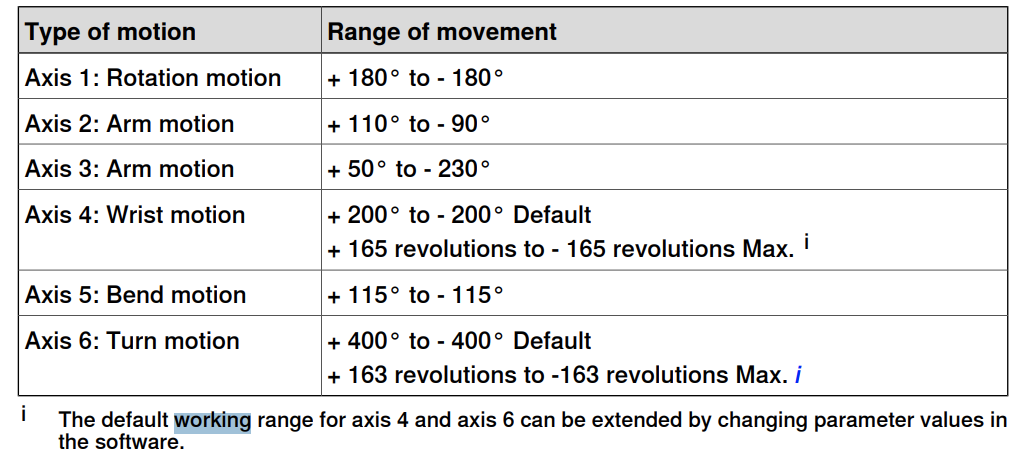

In [22]:
def check_invalid_trajectory(trajectory, center, radius):
  invalid_intersection = False
  center_array = np.array(center)
  radius_squared = radius ** 2
  for point in trajectory:
      if np.sum((np.array(point) - center_array) ** 2) <= radius_squared:
          return True
  return False

def check_joint_range(trajectory, min_joints, max_joints):
  for point in trajectory:
    ibk = irb140_inverse_kinematics_arm(np.array(point))
    if (ibk[0] >= (max_joints[0] * np.pi/180))|(ibk[1] >= (max_joints[1] * np.pi/180))|(ibk[2] >= (max_joints[2] * np.pi/180)):
          return True
    #if (ibk[0] < (min_joints[0] * np.pi/180))|(ibk[1] < (min_joints[1] * np.pi/180))|(ibk[2] < (min_joints[2] * np.pi/180)):
    #      return True
  return False



def generar_angulos_validos(min_joints, max_joints, cantidad, thetas_correction):
    J_sym = symbolic_irb140_forward_kinematics()
    j_1 = []
    j_2 = []
    j_3 = []
    j_4 = []
    j_5 = []
    j_6 = []
    tcp_point = []

    id = 0
    while id < cantidad:
        thetas = np.array([random.uniform(min_joints[i], max_joints[i]) for i in range(6)]) * np.pi/180
        matrixes = irb140_forward_kinematics(J_sym, thetas + thetas_correction)
        tcp_point_actual = matrixes[-1, 0:3, 3]

        if id > 0:
            trajectory = define_line_3d(tcp_point[id-1], tcp_point_actual)
            #if check_invalid_trajectory(trajectory, [70, 0, 352], 350):
            #   continue
            if check_joint_range(trajectory,min_joints[0:3], max_joints[0:3]):
                continue

        j_1.append(thetas[0] * 180/np.pi)
        j_2.append(thetas[1] * 180/np.pi)
        j_3.append(thetas[2] * 180/np.pi)
        j_4.append(thetas[3] * 180/np.pi)
        j_5.append(thetas[4] * 180/np.pi)
        j_6.append(thetas[5] * 180/np.pi)
        tcp_point.append(tcp_point_actual)
        id += 1

    return j_1, j_2, j_3, j_4, j_5, j_6

In [23]:
min_joints = [0, -12, -90, 0, 0, 0]
min_joints[0:3]

[0, -12, -90]

In [24]:
#len(j__1)
J_sym = symbolic_irb140_forward_kinematics()
thetas_p1 = np.array([57.168, 12.134, -82.731, 20.735, 74.071, 43.511]) * np.pi/180
thetas_p2 = np.array([75.240, 68.669, 30.014, 86.986, 25.097, 25.771]) * np.pi/180

tcp_point_p1 = irb140_forward_kinematics(J_sym, thetas_p1 + thetas_correction)[-1,0:3,3]
tcp_point_p2 = irb140_forward_kinematics(J_sym, thetas_p2 + thetas_correction)[-1,0:3,3]

trajectory = define_line_3d(tcp_point_p1, tcp_point_p2)

#question_valid = check_invalid_trajectory(trajectory, [70, 0, 352], 500)

question_valid = check_joint_range(trajectory,[0, -12, -90], [90, 110, 50])

question_valid
#J_sym
#[j__1[1],j__2[1],j__4[1],j__5[1],j__5[1],j__6[1]]

False

In [25]:
irb140_forward_kinematics(J_sym, thetas_p1 + thetas_correction)[-1,0:3,3] #array([171.6084395 , 136.84885328, 803.47491906])

array([ 147.42434718,  228.47746515, 1062.3751234 ])

In [26]:
tcp_point_p1

array([ 147.42434718,  228.47746515, 1062.3751234 ])

In [27]:
#El área esférica está centrada en (70, yc, 352) el radio es 254 (voy a tomar y=0 porque no tengo un valor exacto)
#Los puntos para definir la esfera son (314, y1, 421), (1, y2, 596), (218, y3, 558)

# Función para generar números aleatorios dentro de un rango y guardarlos en un archivo CSV
def generar_valores_IRB140(v_ranges, z_ranges, min_joints, max_joints, cantidad, thetas_correction, nombre_archivo):
    directorio = os.path.dirname(nombre_archivo)
    os.makedirs(directorio, exist_ok=True)
    
    if not os.path.isfile(nombre_archivo) or os.path.getsize(nombre_archivo) == 0:
        # Si el archivo no existe o está vacío, escribir las cabeceras CSV
        with open(nombre_archivo, 'w') as archivo:
            archivo.write('ID, Vel TCP, Pres, Theta_1, Theta_2, Theta_3, Theta_4, Theta_5, Theta_6\n')
    with open(nombre_archivo, 'a') as archivo:
        j_1_array, j_2_array, j_3_array, j_4_array, j_5_array, j_6_array = generar_angulos_validos(min_joints, max_joints, cantidad, thetas_correction)
        for i in range(cantidad):
            id = i
            vel = random.uniform(v_ranges[0], v_ranges[1])
            z = random.uniform(z_ranges[0], z_ranges[1])
            j_1 = j_1_array[i]
            j_2 = j_2_array[i]
            j_3 = j_3_array[i]
            j_4 = j_4_array[i]
            j_5 = j_5_array[i]
            j_6 = j_6_array[i]

            archivo.write(f'{id}, {vel}, {z}, {j_1}, {j_2}, {j_3}, {j_4}, {j_5}, {j_6}\n')


#Rangos de velocidad en mm/s
v_ranges = [10, 200]

#Rangos de presicion en mm
z_ranges = [10, 30]

# Cantidad de números aleatorios a generar
cantidad = 10000
#cantidad = 500 #Con la verificación de que el punto se encuentre en el área positiva del primer cuadrante tarda más
#Para 100 tarda 2 mins y pico


fecha_actual = datetime.now().strftime("%Y-%m-%d")

calculate = True #True
not_limited = False

if calculate:
  if not_limited:
    #Rangos para cada joint -> Completos
    min_joints = [-180, -90, -230, -200, -115, -360]
    max_joints = [180, 110, 50, 200, 115, 360]

    # Nombre del archivo donde se guardarán los ángulos
    nombre_archivo = f'./Pruebas_Iniciales/datos_irb140_{fecha_actual}.csv'
  else:
    #Rangos para cada joint -> Limitados a robconf [0 0 0 0] siendo m incoginita pero m = 0 (z > 0 segun grafico IRB 140 Product Specification)
    min_joints = [0, -12, -90, 0, 0, 0]
    max_joints = [90, 110, 50, 90, 110, 90]

    # Nombre del archivo donde se guardarán los ángulos
    nombre_archivo = f'./Pruebas_Iniciales/datos_irb140_{fecha_actual}_LIMITED_2.csv'


  # Llamada a la función para generar y guardar los ángulos
  generar_valores_IRB140(v_ranges, z_ranges, min_joints, max_joints, cantidad, thetas_correction, nombre_archivo)

  print(f'Se han añadido {cantidad} en el archivo "{nombre_archivo}".')


Se han añadido 10000 en el archivo "./Pruebas_Iniciales/datos_irb140_2025-05-10_LIMITED_2.csv".


# **Filtro Discreto para agregar aceleraciones**
De acuerdo con el paper *Identification of robot forward dynamics via neural network*:

“The corresponding joint accelerations were retrieved through the application of an appropriate discrete filter to the joint velocities just collected.”

Entonces, se tomarán dos datos “de más” (muestra 0 y muestra 101) para permitir aplicar el filtro discreto a las n-2 muestras y tener información de velocidad. Se podrán estudiar otras técnicas para derivar las aceleraciones a partir de las velocidades.




In [ ]:
# Definir una función para calcular las aceleraciones utilizando un filtro de diferencia finita
def calcular_aceleraciones(velocidades, h):
    aceleraciones = []
    for i in range(1, len(velocidades) -1 ):
        # Aplicar el filtro de diferencia finita para calcular la aceleración
        #aceleracion = (velocidades[i + 1] - 2 * velocidades[i] + velocidades[i - 1]) #->Esto no seria la segunda derivada?
        aceleracion = (velocidades[i + 1] -  velocidades[i - 1])/(2*h)
        aceleraciones.append(aceleracion)
    return np.array(aceleraciones)

# Definir una función para calcular las aceleraciones utilizando un filtro de diferencia finita
def calcular_aceleraciones_2(velocidades, h):
    aceleraciones = []
    for i in range(1, len(velocidades) - 4 ):
        # Aplicar el filtro de diferencia finita para calcular la aceleración
        aceleracion = (- velocidades[i + 2] +  8*velocidades[i + 1] - 8*velocidades[i - 2] + velocidades[i - 1]) /(12*h)
        aceleraciones.append(aceleracion)
    return np.array(aceleraciones)

#OJO! Las muestras tomadas no están equiespaciadas en el tiempo -> Por eso la necesidad de crear la interrupción
#La limitación de toma de mediciones resulta 50ms, el paper parece hablar de 20ms
#Investigar cual es el periodo mínimo de tiempo posible entre una medición y otra
#https://es.wikipedia.org/wiki/Derivaci%C3%B3n_num%C3%A9rica

In [ ]:
#files = ['NN_NN','50_50', '50_100', '100_10', '10_100']
#files = ['linear_NN_NN','linear_10_100', 'linear_50_50', 'linear_50_100']
files = ['linear_002_test_NN_NN','linear_002_test_50_50','linear_002_test_10_100','linear_002_test_100_10','linear_002_test_10_50']
num_variables = 6 #len(files)
datos_IRB_140 = {}
datos_IRB_140_st = 'datos_IRB_140_'

tcps_vels = {}
tcps_accus = {}

j_poses = {}
j_vels = {}
j_accels = {}
j_torqs = {}
times = {}

tcp_vel = 'rand_v'
tcp_accu = 'rand_z'

j_pos = 'pos_j'
j_vel = 'vel_j'
j_accel = 'acc_j'
j_torq = 'torq_j'

time_interval = 0.05


for file in range(0,len(files)):
  #print(files[file])
  variable_name = datos_IRB_140_st + files[file] #str(file)
  datos_IRB_140[variable_name] = pd.read_csv(f'./IRB_140/RBSTDIO/DATA/Output_{files[file]}.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
  #print(datos_IRB_140[variable_name].head())
  print(files[file])
  time_var = f"{files[file]}_time"
  times[time_var] = datos_IRB_140[variable_name].iloc[:, 0].values  # Primera columna = tiempo


  tcps_vels_name = str(files[file]) + '_' + tcp_vel
  tcps_vels[tcps_vels_name] = datos_IRB_140[variable_name].iloc[1:-1,3].values
  tcps_accus_name = str(files[file]) + '_' + tcp_accu
  tcps_accus[tcps_accus_name] = datos_IRB_140[variable_name].iloc[1:-1,4].values

  for i in range(1, num_variables + 1):
    pos_j_name = str(files[file]) + '_' + j_pos + str(i)
    j_poses[pos_j_name] = datos_IRB_140[variable_name].iloc[:,4+i].values * np.pi / 180

    vel_j_name = str(files[file]) + '_' + j_vel + str(i)
    j_vels[vel_j_name] = datos_IRB_140[variable_name].iloc[:,10+i].values * np.pi / 180

    torq_j_name = str(files[file]) + '_' + j_torq + str(i)
    j_torqs[torq_j_name] = datos_IRB_140[variable_name].iloc[:,16+i].values 

    acc_j_name = str(files[file]) + '_' + j_accel + str(i)
    j_accels[acc_j_name]= calcular_aceleraciones(j_vels[vel_j_name], time_interval) * np.pi / 180 #https://en.wikipedia.org/wiki/Five-point_stencil https://web.media.mit.edu/~crtaylor/calculator.html


linear_002_test_NN_NN
linear_002_test_50_50
linear_002_test_10_100
linear_002_test_100_10
linear_002_test_10_50


In [ ]:
files = ['50_50', '50_100', '100_10', '10_100', 'NN_NN_New_2', 'NN_NN_New']

for file in range(0,len(files)):
  #print(files[file])
  variable_name = datos_IRB_140_st + files[file] #str(file)
  datos_IRB_140[variable_name] = pd.read_csv(f'./IRB_140/RBSTDIO/DATA/Output_{files[file]}.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
  #print(datos_IRB_140[variable_name].head())
  print(files[file])
  time_var = f"{files[file]}_time"
  times[time_var] = datos_IRB_140[variable_name].iloc[:, 0].values  # Primera columna = tiempo


  tcps_vels_name = str(files[file]) + '_' + tcp_vel
  tcps_vels[tcps_vels_name] = datos_IRB_140[variable_name].iloc[1:-1,3].values
  tcps_accus_name = str(files[file]) + '_' + tcp_accu
  tcps_accus[tcps_accus_name] = datos_IRB_140[variable_name].iloc[1:-1,4].values

  for i in range(1, num_variables + 1):
    pos_j_name = str(files[file]) + '_' + j_pos + str(i)
    j_poses[pos_j_name] = datos_IRB_140[variable_name].iloc[:,4+i].values * (np.pi / 180.0)

    vel_j_name = str(files[file]) + '_' + j_vel + str(i)
    j_vels[vel_j_name] = datos_IRB_140[variable_name].iloc[:,10+i].values * (np.pi / 180.0)

    torq_j_name = str(files[file]) + '_' + j_torq + str(i)
    j_torqs[torq_j_name] = datos_IRB_140[variable_name].iloc[:,16+i].values 

    acc_j_name = str(files[file]) + '_' + j_accel + str(i)
    j_accels[acc_j_name]= calcular_aceleraciones(j_vels[vel_j_name], time_interval) * (np.pi / 180.0) #https://en.wikipedia.org/wiki/Five-point_stencil https://web.media.mit.edu/~crtaylor/calculator.html


50_50
50_100
100_10
10_100
NN_NN_New_2
NN_NN_New


In [ ]:
tcps_vels['NN_NN_New_rand_v']
tcps_accus['NN_NN_New_rand_z']

j_poses['NN_NN_New_pos_j1']
j_poses['NN_NN_New_pos_j2']
j_poses['NN_NN_New_pos_j3']
j_poses['NN_NN_New_pos_j4']
j_poses['NN_NN_New_pos_j5']
j_poses['NN_NN_New_pos_j6']

j_vels['NN_NN_New_vel_j1']
j_vels['NN_NN_New_vel_j2']
j_vels['NN_NN_New_vel_j3']
j_vels['NN_NN_New_vel_j4']
j_vels['NN_NN_New_vel_j5']
j_vels['NN_NN_New_vel_j6']

j_torqs['NN_NN_New_torq_j1']
j_torqs['NN_NN_New_torq_j2']
j_torqs['NN_NN_New_torq_j3']
j_torqs['NN_NN_New_torq_j4']
j_torqs['NN_NN_New_torq_j5']
j_torqs['NN_NN_New_torq_j6']

j_accels['NN_NN_New_acc_j1']
j_accels['NN_NN_New_acc_j2']
j_accels['NN_NN_New_acc_j3']
j_accels['NN_NN_New_acc_j4']
j_accels['NN_NN_New_acc_j5']
j_accels['NN_NN_New_acc_j6']

array([-8.37697904e-04,  2.58010955e-04,  2.59534042e-04, ...,
        5.78773098e-06,  5.84865446e-06,  5.87911620e-06], shape=(198384,))

(34423,)
(34416,)
(34428,)
(34440,)
(99999,)
(198386,)


Text(0.5, 1.0, 'Torques ${\\tau_{1}}$')

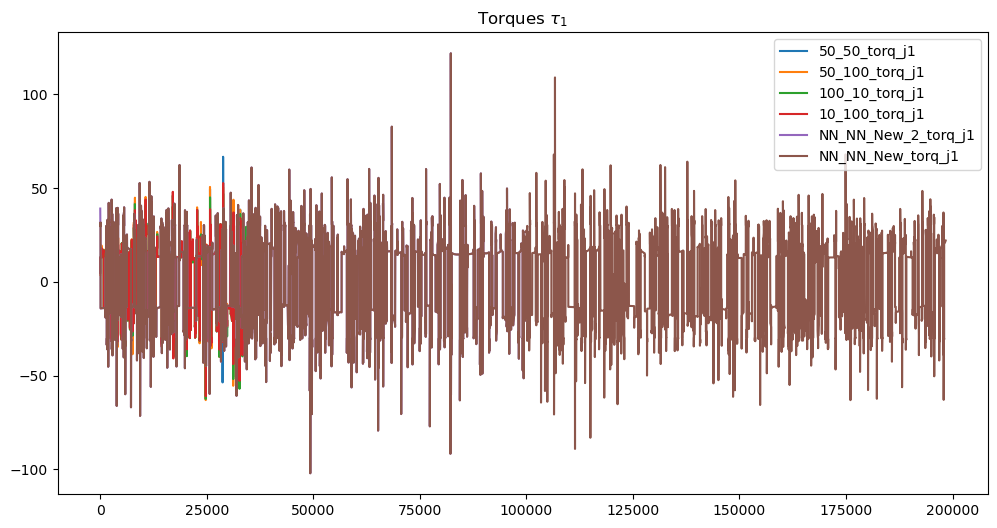

In [ ]:
plt.figure(figsize=(12, 6)) 
for file in range(0,len(files)):
  item = str(files[file]) + '_' + j_torq + '1'
  print(j_torqs[item].shape)
  plt.plot(j_torqs[item],label=item)


plt.legend()
#plt.xlim([277,285])
#plt.ylim([-10, 100])
#plt.xlim([35000,37000])
plt.show
plt.title(r'Torques ${\tau_{1}}$')

(34423,)
(34416,)
(34428,)
(34440,)
(99999,)
(198386,)


Text(0.5, 1.0, 'Posiciones ${\\theta_{1}}$')

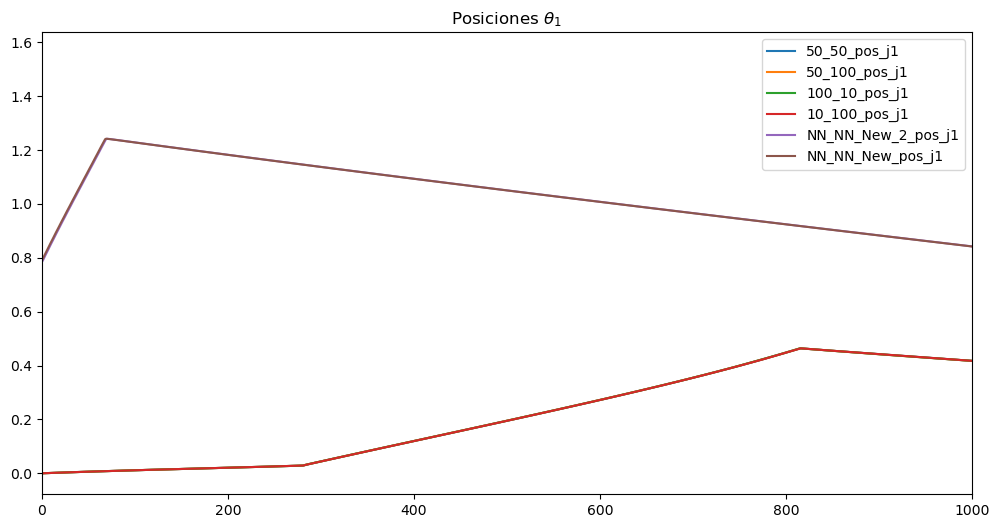

In [ ]:
plt.figure(figsize=(12, 6)) 
for file in range(0,len(files)):
  item = str(files[file]) + '_' + j_pos + '1'
  print(j_poses[item].shape)
  plt.plot(j_poses[item],label=item)


plt.legend()
plt.xlim([0,1000])
#plt.ylim([0,10])  
plt.show
plt.title(r'Posiciones ${\theta_{1}}$')

(34423,)
(34416,)
(34428,)
(34440,)
(99999,)
(198386,)


Text(0.5, 1.0, 'Velocidades $\\dot{\\theta_{1}}$')

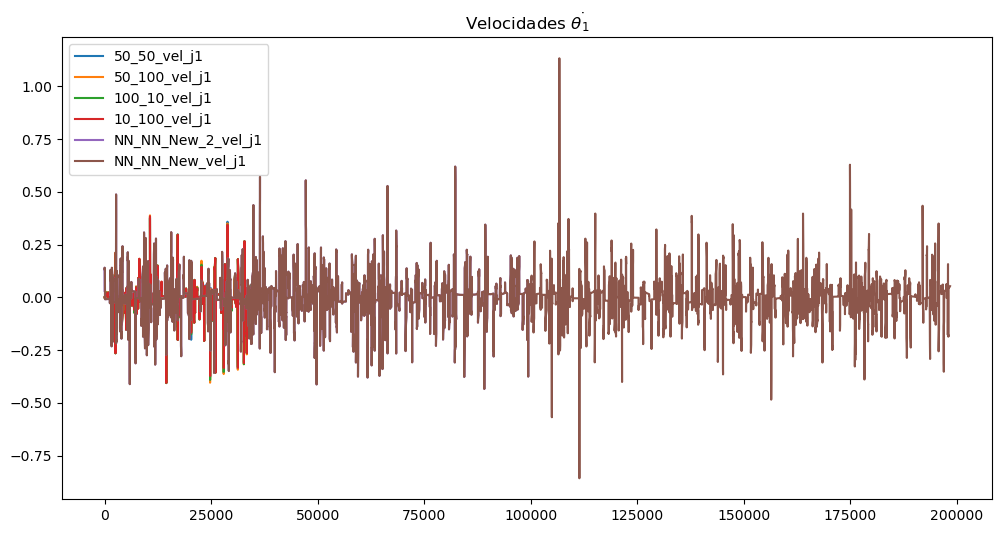

In [ ]:
plt.figure(figsize=(12, 6)) 
for file in range(0,len(files)):
  item = str(files[file]) + '_' + j_vel + '1'
  print(j_vels[item].shape)
  plt.plot(j_vels[item],label=item)


plt.legend()
plt.show
plt.title(r'Velocidades $\dot{\theta_{1}}$')

(34421,)
(34414,)
(34426,)
(34438,)
(99997,)
(198384,)


Text(0.5, 1.0, 'Aceleraciones $\\ddot{\\theta_{1}}$')

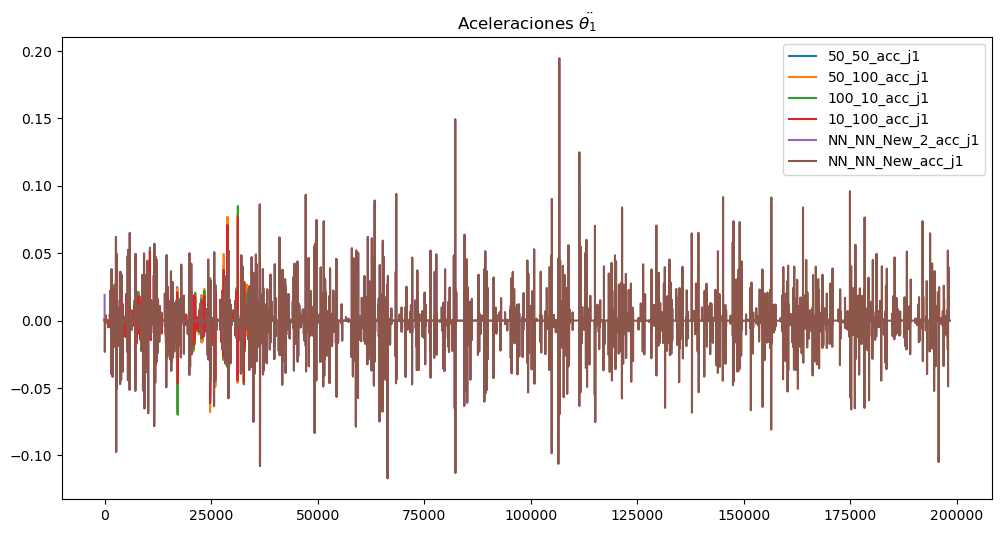

In [ ]:
plt.figure(figsize=(12, 6)) 
for file in range(0,len(files)):
  item = str(files[file]) + '_' + j_accel + '1'
  print(j_accels[item].shape)
  plt.plot(j_accels[item],label=item)


plt.legend()
plt.show
plt.title(r'Aceleraciones $\ddot{\theta_{1}}$')

(34421,)
(34414,)
(34426,)
(34438,)
(99997,)
(198384,)


Text(0.5, 1.0, 'Aceleraciones $\\ddot{\\theta_{2}}$')

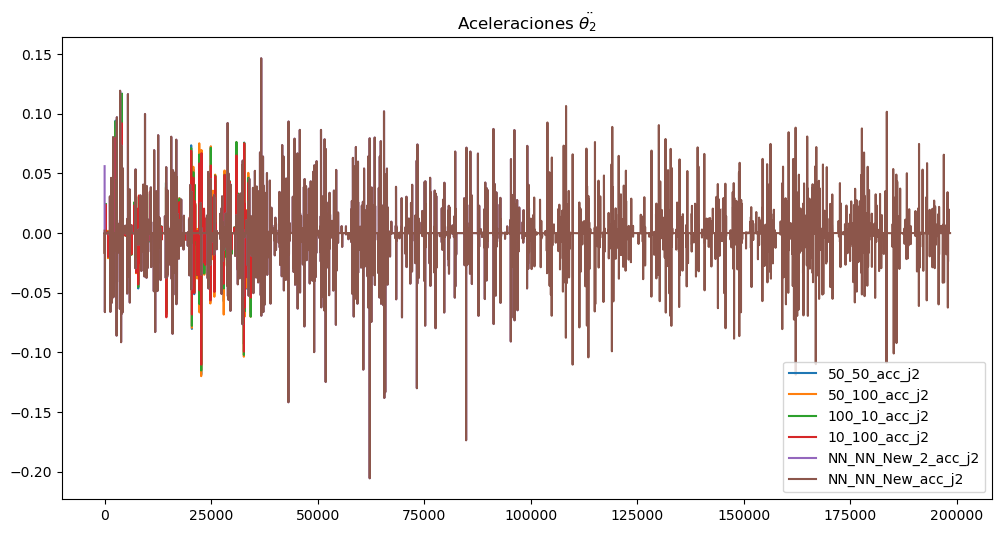

In [ ]:
plt.figure(figsize=(12, 6)) 
for file in range(0,len(files)):
  item = str(files[file]) + '_' + j_accel + '2'
  print(j_accels[item].shape)
  plt.plot(j_accels[item],label=item)


plt.legend()
plt.show
plt.title(r'Aceleraciones $\ddot{\theta_{2}}$')

(34421,)
(34414,)
(34426,)
(34438,)
(99997,)
(198384,)


Text(0.5, 1.0, 'Aceleraciones $\\ddot{\\theta_{3}}$')

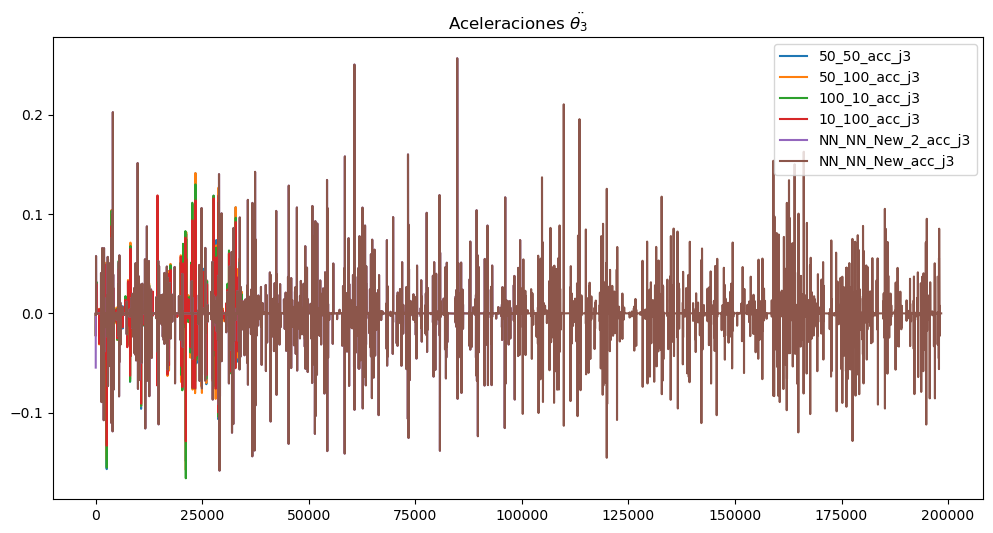

In [ ]:
plt.figure(figsize=(12, 6)) 
for file in range(0,len(files)):
  item = str(files[file]) + '_' + j_accel + '3'
  print(j_accels[item].shape)
  plt.plot(j_accels[item],label=item)


plt.legend()
plt.show
plt.title(r'Aceleraciones $\ddot{\theta_{3}}$')

(34421,)
(34414,)
(34426,)
(34438,)
(99997,)
(198384,)


Text(0.5, 1.0, 'Aceleraciones $\\ddot{\\theta_{4}}$')

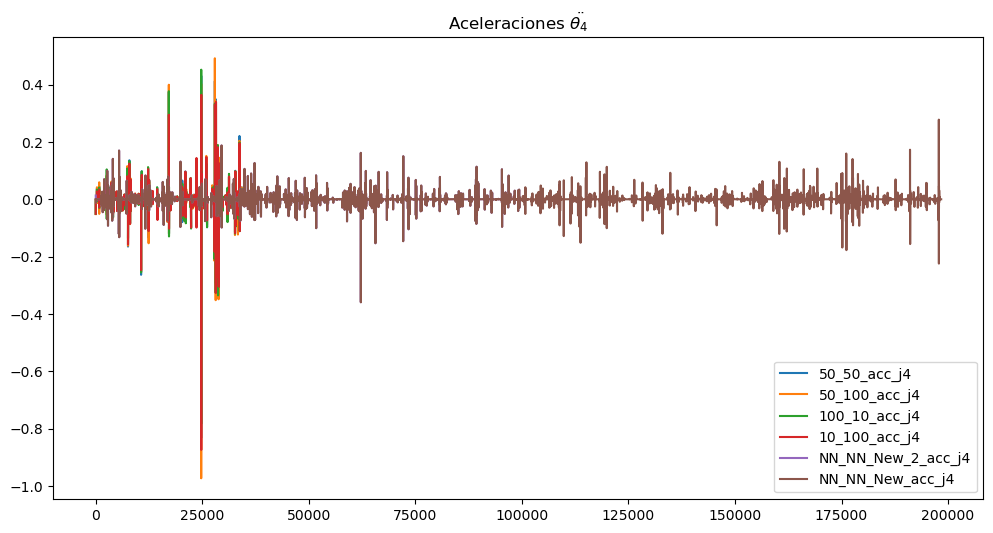

In [ ]:
plt.figure(figsize=(12, 6)) 

for file in range(0,len(files)):
  item = str(files[file]) + '_' + j_accel + '4'
  print(j_accels[item].shape)
  plt.plot(j_accels[item],label=item)


plt.legend()
#plt.xlim([0,100])
plt.show
plt.title(r'Aceleraciones $\ddot{\theta_{4}}$')

(34421,)
(34414,)
(34426,)
(34438,)
(99997,)
(198384,)


Text(0.5, 1.0, 'Aceleraciones $\\ddot{\\theta_{5}}$')

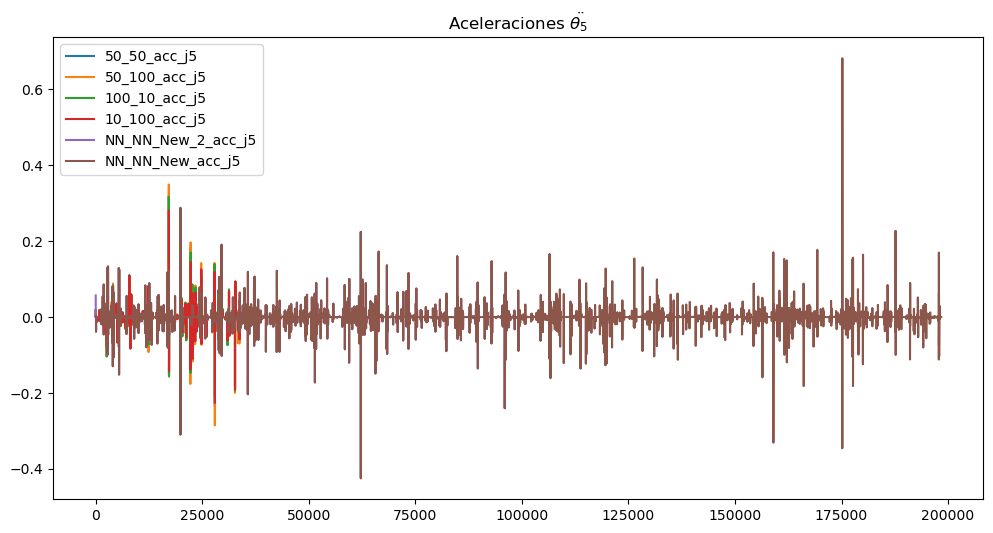

In [ ]:
plt.figure(figsize=(12, 6)) 
for file in range(0,len(files)):
  item = str(files[file]) + '_' + j_accel + '5'
  print(j_accels[item].shape)
  plt.plot(j_accels[item],label=item)


plt.legend()
#plt.xlim([277,285])
#plt.ylim([-10, 100])
#plt.xlim([35000,37000])
plt.show
plt.title(r'Aceleraciones $\ddot{\theta_{5}}$')

(34421,)
(34414,)
(34426,)
(34438,)
(99997,)
(198384,)


Text(0.5, 1.0, 'Aceleraciones $\\ddot{\\theta_{6}}$')

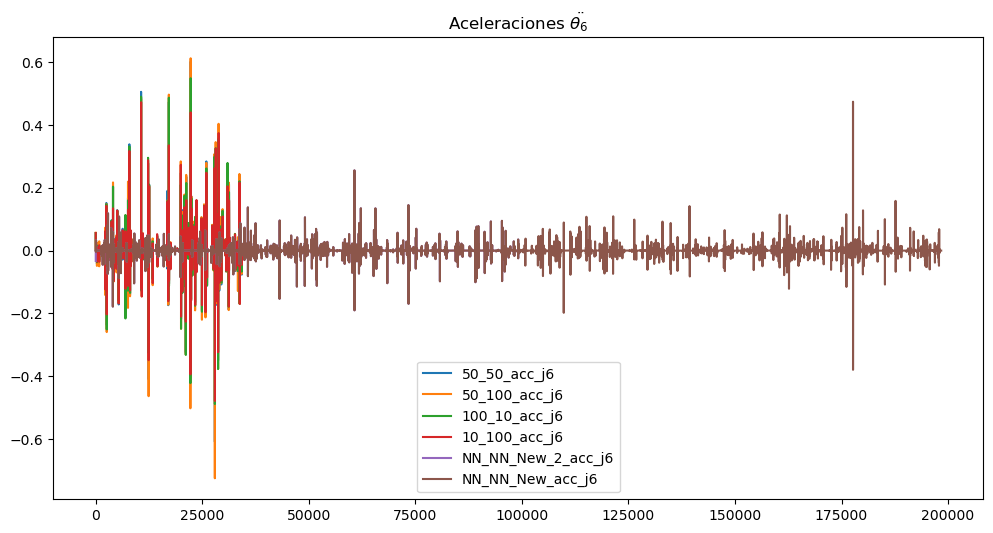

In [ ]:
plt.figure(figsize=(12, 6)) 
for file in range(0,len(files)):
  item = str(files[file]) + '_' + j_accel + '6'
  print(j_accels[item].shape)
  plt.plot(j_accels[item],label=item)


plt.legend()
#plt.xlim([277,285])
#plt.ylim([-10, 100])
#plt.xlim([35000,37000])
plt.show
plt.title(r'Aceleraciones $\ddot{\theta_{6}}$')

# **PROBLEMA DINAMICO DIRECTO**:

**Red neuronal Secuencial encontrar posición siguiente**:

In [ ]:
import math
import numpy as np
import keras 
import tensorflow as tf
import datetime
import json
import os
#from tensorflow import keras
from keras.models import Sequential #One of the most important classes in tensorflow, used to creare NN (Named after NN as a sequence of layers)
from keras.layers import Input, Dense, LSTM, BatchNormalization, Dropout, InputLayer #Dense layer means that one neuron in one layer is connected to all neurons in the next layer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from keras.regularizers import l2, l1, l1_l2
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
#from keras_tuner import RandomSearch

In [ ]:
#linear_002
j_poses['linear_002_test_10_100_pos_j1'].shape
j_vels['linear_002_test_10_100_vel_j1'].shape
j_accels['linear_002_test_10_100_acc_j1'].shape
j_torqs['linear_002_test_10_100_torq_j1'][1:-1].shape

(40553,)

In [ ]:
#Inputs ---> uk=[qTk-1  d_qTk-1  tauTk]T
time_joint= times['NN_NN_New_time'][0:-2]

pos_j1 = j_poses['NN_NN_New_pos_j1'][0:-2]  #34440 -> 34438, k
pos_j2 = j_poses['NN_NN_New_pos_j2'][0:-2]
pos_j3 = j_poses['NN_NN_New_pos_j3'][0:-2] 
pos_j4 = j_poses['NN_NN_New_pos_j4'][0:-2] 
pos_j5 = j_poses['NN_NN_New_pos_j5'][0:-2] 
pos_j6 = j_poses['NN_NN_New_pos_j6'][0:-2] 

vels_j1 = j_vels['NN_NN_New_vel_j1'][1:-1]  #34440 -> 34438 k
vels_j2 = j_vels['NN_NN_New_vel_j2'][1:-1] 
vels_j3 = j_vels['NN_NN_New_vel_j3'][1:-1] 
vels_j4 = j_vels['NN_NN_New_vel_j4'][1:-1] 
vels_j5 = j_vels['NN_NN_New_vel_j5'][1:-1] 
vels_j6 = j_vels['NN_NN_New_vel_j6'][1:-1] 

torq_j1 = j_torqs['NN_NN_New_torq_j1'][1:-1]  #34440 -> 34438 k
torq_j2 = j_torqs['NN_NN_New_torq_j2'][1:-1] 
torq_j3 = j_torqs['NN_NN_New_torq_j3'][1:-1] 
torq_j4 = j_torqs['NN_NN_New_torq_j4'][1:-1] 
torq_j5 = j_torqs['NN_NN_New_torq_j5'][1:-1] 
torq_j6 = j_torqs['NN_NN_New_torq_j6'][1:-1] 

#Outputs
accs_j1 = j_accels['NN_NN_New_acc_j1']  #34438 k
accs_j2 = j_accels['NN_NN_New_acc_j2'] 
accs_j3 = j_accels['NN_NN_New_acc_j3'] 
accs_j4 = j_accels['NN_NN_New_acc_j4'] 
accs_j5 = j_accels['NN_NN_New_acc_j5'] 
accs_j6 = j_accels['NN_NN_New_acc_j6'] 


pos_next_j1 = j_poses['NN_NN_New_pos_j1'][1:-1]  #34440 -> 34438, k
pos_next_j2 = j_poses['NN_NN_New_pos_j2'][1:-1] 
pos_next_j3 = j_poses['NN_NN_New_pos_j3'][1:-1] 
pos_next_j4 = j_poses['NN_NN_New_pos_j4'][1:-1] 
pos_next_j5 = j_poses['NN_NN_New_pos_j5'][1:-1] 
pos_next_j6 = j_poses['NN_NN_New_pos_j6'][1:-1] 

In [ ]:
#inputs = np.vstack((pos_j1, pos_j2, pos_j3, pos_j4, pos_j5, pos_j6, vels_j1, vels_j2, vels_j3, vels_j4, vels_j5, vels_j6, torq_j1, torq_j2, torq_j3, torq_j4, torq_j5, torq_j6)).T
inputs = np.vstack((pos_j1, pos_j2, pos_j3, pos_j4, pos_j5, pos_j6, torq_j1, torq_j2, torq_j3, torq_j4, torq_j5, torq_j6)).T
#Aca dudo si es mejor calcular todos los outputs de una, o de a uno
#outputs = np.vstack((accs_j1, accs_j2, accs_j3, accs_j4, accs_j5, accs_j6)).T
outputs = np.vstack((pos_next_j1,pos_next_j2,pos_next_j3,pos_next_j4,pos_next_j5,pos_next_j6)).T

In [ ]:
inputs.shape

(198384, 12)

In [ ]:
outputs.shape

(198384, 6)

In [ ]:
# Defino el conjunto de datos que voy a usar para entrenar y el que voy a usar para validar (test) -> Porcentajes similares al usados en el paper
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)
X_train.shape #Verifico que el 80% se usa para entrenar a la red

(143332, 12)

In [ ]:
#Tengo que hacer preprocesado de los datos para que los calculos no sean tan pesados
scaler1_ss = StandardScaler()
X_train = scaler1_ss.fit_transform(X_train)#Primero se llama a la funcion fit para que ajuste los datos
X_test = scaler1_ss.transform(X_test) #Una vez que los datos fueron ajustados se puede llamar a la transformacion directamente
X_val = scaler1_ss.transform(X_val)

#Lo mismo para los outputs
scaler2_ss = StandardScaler() #Otra forma de ESCALAR ---> scaler = StandardScaler()
y_train = scaler2_ss.fit_transform(y_train)
y_test = scaler2_ss.transform(y_test)
y_val = scaler2_ss.transform(y_val)

In [ ]:
# 18 -> 12 -> 12 -> 12 > 12 -> 6
FF_DD_network = Sequential()
#Definition of input and first hidden layer (using relu function for activation)
#Input only for the first layer
FF_DD_network.add(Dense(100,input_shape = (inputs.shape[1],), activation = 'tanh'))
#Definition of second hidden layer (using relu function for activation)
FF_DD_network.add(Dense(100, activation='tanh'))
FF_DD_network.add(Dense(100, activation='tanh'))
#FF_DD_network.add(Dense(100, activation='tanh'))
#Output layer sin activation ya que es un problema de regresion
FF_DD_network.add(Dense(6))

FF_DD_network.summary()

/Users/melinagabrielacheminet/Downloads/TPP/.conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,206 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,006 (171.90 KB)

 Trainable params: 44,006 (171.90 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#FF_DD_network.compile(loss = 'mean_squared_error', optimizer='adam', metrics = ['mae']) #adam me da mejor que sgd
FF_DD_network.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics = ['mae'])#Que pasa si uso SGD con learning rate

In [ ]:
DD_checkpoint_cb = keras.callbacks.ModelCheckpoint("./IRB_140/RBSTDIO/MODELS/DD/FF_NN_best_model.keras", save_best_only=True)
DD_early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, min_delta=1E-10, restore_best_weights=True)


In [ ]:
#Deberia agregar un dataset adicional cosa de tener forma de validar los hiperparametros de la red -> validation_data=(X_valid, y_valid)
#history = FF_DD_network.fit(X_train, y_train, batch_size=100, epochs=100, callbacks=[checkpoint_cb])#con 100 epochs me da mejor q con 50 pero tarda 4 veces más y no mejora la accuracy
history = FF_DD_network.fit(X_train, y_train, batch_size=64, epochs=1000, validation_data=(X_val, y_val), callbacks=[DD_checkpoint_cb, DD_early_stopping_cb])

Epoch 1/1000
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.4316 - mae: 0.4764 - val_loss: 0.0045 - val_mae: 0.0493
Epoch 2/1000
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0041 - mae: 0.0472 - val_loss: 0.0038 - val_mae: 0.0451
Epoch 3/1000
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0036 - mae: 0.0441 - val_loss: 0.0032 - val_mae: 0.0410
Epoch 4/1000
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0030 - mae: 0.0399 - val_loss: 0.0026 - val_mae: 0.0372
Epoch 5/1000
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0025 - mae: 0.0361 - val_loss: 0.0021 - val_mae: 0.0335
Epoch 6/1000
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0020 - mae: 0.0327 - val_loss: 0.0018 - val_mae: 0.0312
Epoch 7/1000
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0017 - mae: 0.0303 - val_loss: 0.0016 - val_mae: 0.0289
Epoch 8/1000
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0015 - mae: 0.0284 - val_loss: 0.0014 - val_mae: 0.0270
Epoch 9/1000
2240/2240 ━

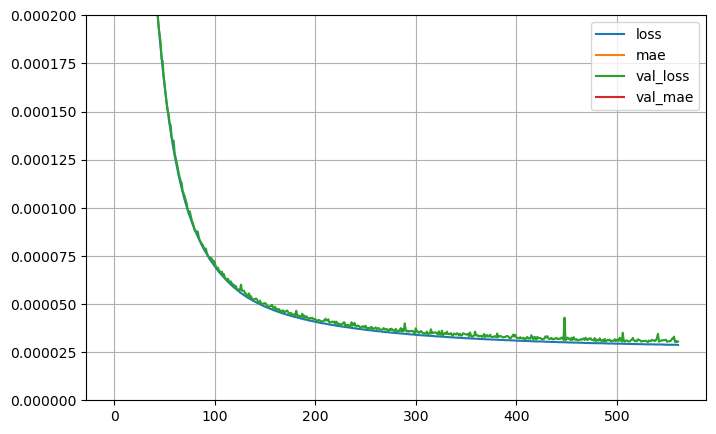

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0, 2e-4)
plt.show()

In [ ]:
#We evaluate the NN
accuracy_test = FF_DD_network.evaluate(X_test, y_test)

930/930 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7858e-05 - mae: 0.0030


In [ ]:
predictions = FF_DD_network.predict(X_test)

930/930 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
predictions[0]

array([ 1.3495317 , -1.4100432 , -0.5342692 , -1.1032814 , -0.7527366 ,
        0.05454814], dtype=float32)

In [ ]:
y_test[0]

array([ 1.34646698, -1.4185997 , -0.54226372, -1.10279242, -0.74841238,
        0.0547963 ])

In [ ]:
predictions[:,0]

array([ 1.3495317 ,  0.72317964, -0.41752493, ..., -0.0919544 ,
       -0.7623962 ,  0.5048992 ], shape=(29758,), dtype=float32)

# **Red neuronal LSTM**

In [ ]:
#inputs = np.vstack((pos_j1, pos_j2, pos_j3, pos_j4, pos_j5, pos_j6, vels_j1, vels_j2, vels_j3, vels_j4, vels_j5, vels_j6, torq_j1, torq_j2, torq_j3, torq_j4, torq_j5, torq_j6)).T
inputs = np.vstack((pos_j1, pos_j2, pos_j3, pos_j4, pos_j5, pos_j6, torq_j1, torq_j2, torq_j3, torq_j4, torq_j5, torq_j6)).T
#outputs = np.vstack((accs_j1, accs_j2, accs_j3, accs_j4, accs_j5, accs_j6)).T
outputs = np.vstack((pos_next_j1,pos_next_j2,pos_next_j3,pos_next_j4,pos_next_j5,pos_next_j6)).T

In [ ]:
def create_lstm_sequences(inputs, outputs, time_joint, window_size=6, split=0.7):
    """
    Genera secuencias de entrada y salida para una LSTM a partir de los datos de posición, velocidad, aceleración y torque.
    
    Args:
        inputs: Matriz de entrada que contiene las posiciones, velocidades y aceleraciones.
        outputs: Matriz de salida que contiene los torques.
        time_joint: Vector de tiempo asociado a los datos.
        window_size: Tamaño de la ventana de tiempo para la LSTM.
        split: Proporción del dataset que se utiliza para entrenamiento (el resto para prueba).
        
    Returns:
        X_train: Secuencias de entrada para entrenamiento.
        Y_train: Secuencias de salida para entrenamiento.
        X_test: Secuencias de entrada para prueba.
        Y_test: Secuencias de salida para prueba.
        t_test: Vector de tiempo correspondiente al conjunto de prueba.
    """
    # Preparar las secuencias de entrada y salida usando ventanas deslizantes
    input_sequences = []
    output_sequences = []
    
    for i in range(len(inputs) - window_size):
        input_sequences.append(inputs[i:i+window_size])
        output_sequences.append(outputs[i+window_size])
    
    # Convertir a arrays numpy
    X = np.array(input_sequences)
    Y = np.array(output_sequences)
    
    # Dividir en conjuntos de entrenamiento y prueba
    if split > 0 and split < 1:
        idx_split = int(split * len(X))
        X_train, X_test = X[:idx_split], X[idx_split:]
        Y_train, Y_test = Y[:idx_split], Y[idx_split:]
        t_test = time_joint[idx_split:-window_size-len(inputs)]
    else:
        X_train, X_test = X, None
        Y_train, Y_test = Y, None
        t_test = time_joint[:-window_size-len(inputs)]
    
    return X_train, Y_train, X_test, Y_test, t_test

In [ ]:
w_size=40
# Aplicar StandardScaler
scaler1_LSTM = StandardScaler() #MinMaxScaler()#feature_range=(0, 1)) #RobustScaler() #MinMaxScaler() #StandardScaler()
inputs = scaler1_LSTM.fit_transform(inputs)

scaler2_LSTM = StandardScaler() #MinMaxScaler()#feature_range=(0, 1)) #RobustScaler() #MinMaxScaler() #StandardScaler()
outputs = scaler2_LSTM.fit_transform(outputs)

X_train_LSTM, y_train_LSTM, X_test_LSTM, y_test_LSTM, t_test_LSTM  = create_lstm_sequences(inputs, outputs, time_joint, window_size=w_size, split=0.8)

In [ ]:
inputs.shape

(198384, 12)

In [ ]:
LSTM_network = Sequential()
#LSTM_network.add(LSTM(30, input_shape=(w_size, X_train_LSTM.shape[2]), activation='tanh', kernel_regularizer=l2(1e-6)))
LSTM_network.add(LSTM(20, input_shape=(w_size, X_train_LSTM.shape[2]), activation='tanh', return_sequences=True))
#LSTM_network.add(LSTM(10, activation='tanh', return_sequences=True, kernel_regularizer=l2(1e-6)))
#LSTM_network.add(LSTM(20, activation='tanh'))
# Output layer (no activation for regression)
LSTM_network.add(Dense(outputs.shape[1]))
# Compile the model
LSTM_network.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=1E-3), metrics = ['mae'])
LSTM_network.summary()

/Users/melinagabrielacheminet/Downloads/TPP/.conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 40, 20)         │         2,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,046 (23.62 KB)

 Trainable params: 6,046 (23.62 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#LSTM_checkpoint_cb = keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/CT_p/Modelos_NN/LSTM_NN_EPOCHS/lstm_nn-{epoch:02d}.h5")
LSTM_checkpoint_cb = keras.callbacks.ModelCheckpoint("./IRB_140/RBSTDIO/MODELS/DD/LSTM/LSTM_nn_Best_Model.keras", save_best_only=True)
LSTM_early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

In [ ]:
LSTM_history = LSTM_network.fit(X_train_LSTM, y_train_LSTM, batch_size=64, epochs=1000, validation_data=(X_test_LSTM, y_test_LSTM), callbacks=[LSTM_checkpoint_cb, LSTM_early_stopping_cb])
#LSTM_history = LSTM_network.fit(X_train, y_train, batch_size=100, epochs=100, callbacks=[LSTM_checkpoint_cb])

Epoch 1/1000
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 85s 33ms/step - loss: 0.1412 - mae: 0.2086 - val_loss: 0.0014 - val_mae: 0.0254
Epoch 2/1000
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - loss: 8.0614e-04 - mae: 0.0195 - val_loss: 5.5992e-04 - val_mae: 0.0158
Epoch 3/1000
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 83s 33ms/step - loss: 3.2039e-04 - mae: 0.0124 - val_loss: 3.3401e-04 - val_mae: 0.0123
Epoch 4/1000
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - loss: 1.8851e-04 - mae: 0.0095 - val_loss: 1.8616e-04 - val_mae: 0.0083
Epoch 5/1000
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 86s 35ms/step - loss: 1.2497e-04 - mae: 0.0077 - val_loss: 1.6308e-04 - val_mae: 0.0083
Epoch 6/1000
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 87s 35ms/step - loss: 1.0382e-04 - mae: 0.0070 - val_loss: 1.4527e-04 - val_mae: 0.0080
Epoch 7/1000
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 86s 35ms/step - loss: 8.8530e-05 - mae: 0.0065 - val_loss: 1.1000e-04 - val_mae: 0.0066
Epoch 8/1000
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 89s 36ms/step - loss: 7.6008e-05 - mae: 

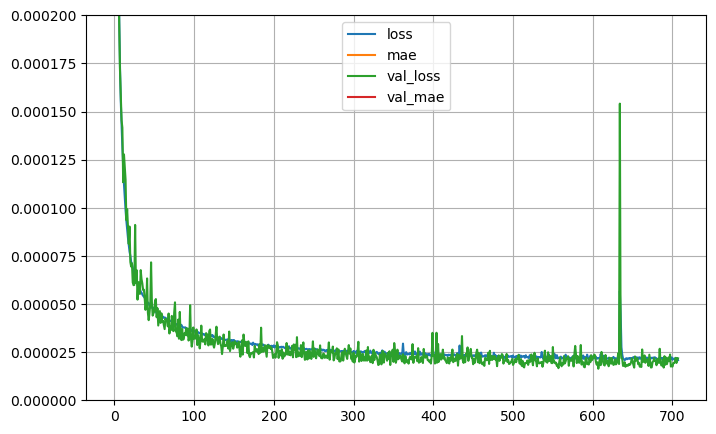

In [ ]:
pd.DataFrame(LSTM_history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_xlim(0, 1)
plt.gca().set_ylim(0, 2e-6)
plt.show()

In [ ]:
LSTM_accuracy_test = LSTM_network.evaluate(X_test_LSTM, y_test_LSTM)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.5752e-05 - mae: 0.0016


In [ ]:
LSTM_predictions = LSTM_network.predict(X_test_LSTM)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [ ]:
LSTM_predictions[0]

array([-1.0060227 ,  0.20976327, -0.52579796,  1.3072456 , -0.26444164,
        1.6173815 ], dtype=float32)

In [ ]:
y_test_LSTM[0]

array([-1.00673203,  0.20844848, -0.52625191,  1.30603091, -0.26374454,
        1.61801717])

*   [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)



# **Comparación de Modelos NN**

In [ ]:
inputs_ref = np.vstack((pos_j1, pos_j2, pos_j3, pos_j4, pos_j5, pos_j6, torq_j1, torq_j2, torq_j3, torq_j4, torq_j5, torq_j6)).T
outputs_ref = np.vstack((pos_next_j1,pos_next_j2,pos_next_j3,pos_next_j4,pos_next_j5,pos_next_j6)).T

In [ ]:
inputs_ref

array([[ 0.78471225,  0.44282319,  0.04763161, ...,  5.71552   ,
        14.113     , -3.43055   ],
       [ 0.78924138,  0.45566533,  0.03551012, ...,  5.76497   ,
        14.1114    , -3.45299   ],
       [ 0.7965386 ,  0.476152  ,  0.01639969, ...,  5.7592    ,
        14.1114    , -3.45015   ],
       ...,
       [ 0.31623621,  1.19605319, -1.54158475, ...,  1.93942   ,
         7.6786    ,  2.65019   ],
       [ 0.31462527,  1.19812315, -1.54222354, ...,  1.93929   ,
         7.67856   ,  2.65018   ],
       [ 0.31288168,  1.20036416, -1.54291469, ...,  1.93917   ,
         7.67853   ,  2.65017   ]], shape=(99997, 12))

In [ ]:
inputs_ref.shape

(99997, 12)

In [ ]:
q_sim_FF_NN = scaler2_ss.inverse_transform(FF_DD_network.predict(scaler1_ss.transform(inputs_ref)))
#OSA_predictions = scaler2_osa.inverse_transform(ffnn_osa_predictions)


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 542us/step


In [ ]:
def create_sequences_with_time(data, time, window_size= w_size):
    sequences = []
    times = []
    
    for i in range(len(data) - window_size + 1):
        sequence = data[i:i + window_size]
        sequences.append(sequence)
        
        # Obtener el tiempo correspondiente al centro de la ventana
        time_center = time[i + window_size // 2]  # Usa el centro de la ventana
        times.append(time_center)
    
    return np.array(sequences), np.array(times)

X_test_scaled_LSTM = scaler1_LSTM.transform(inputs_ref)
X_test_windowed_LSTM, t_ref_LSTM = create_sequences_with_time(X_test_scaled_LSTM, time_joint)
q_sim_LSTM = scaler2_LSTM.inverse_transform(LSTM_network.predict(X_test_windowed_LSTM))

3124/3124 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


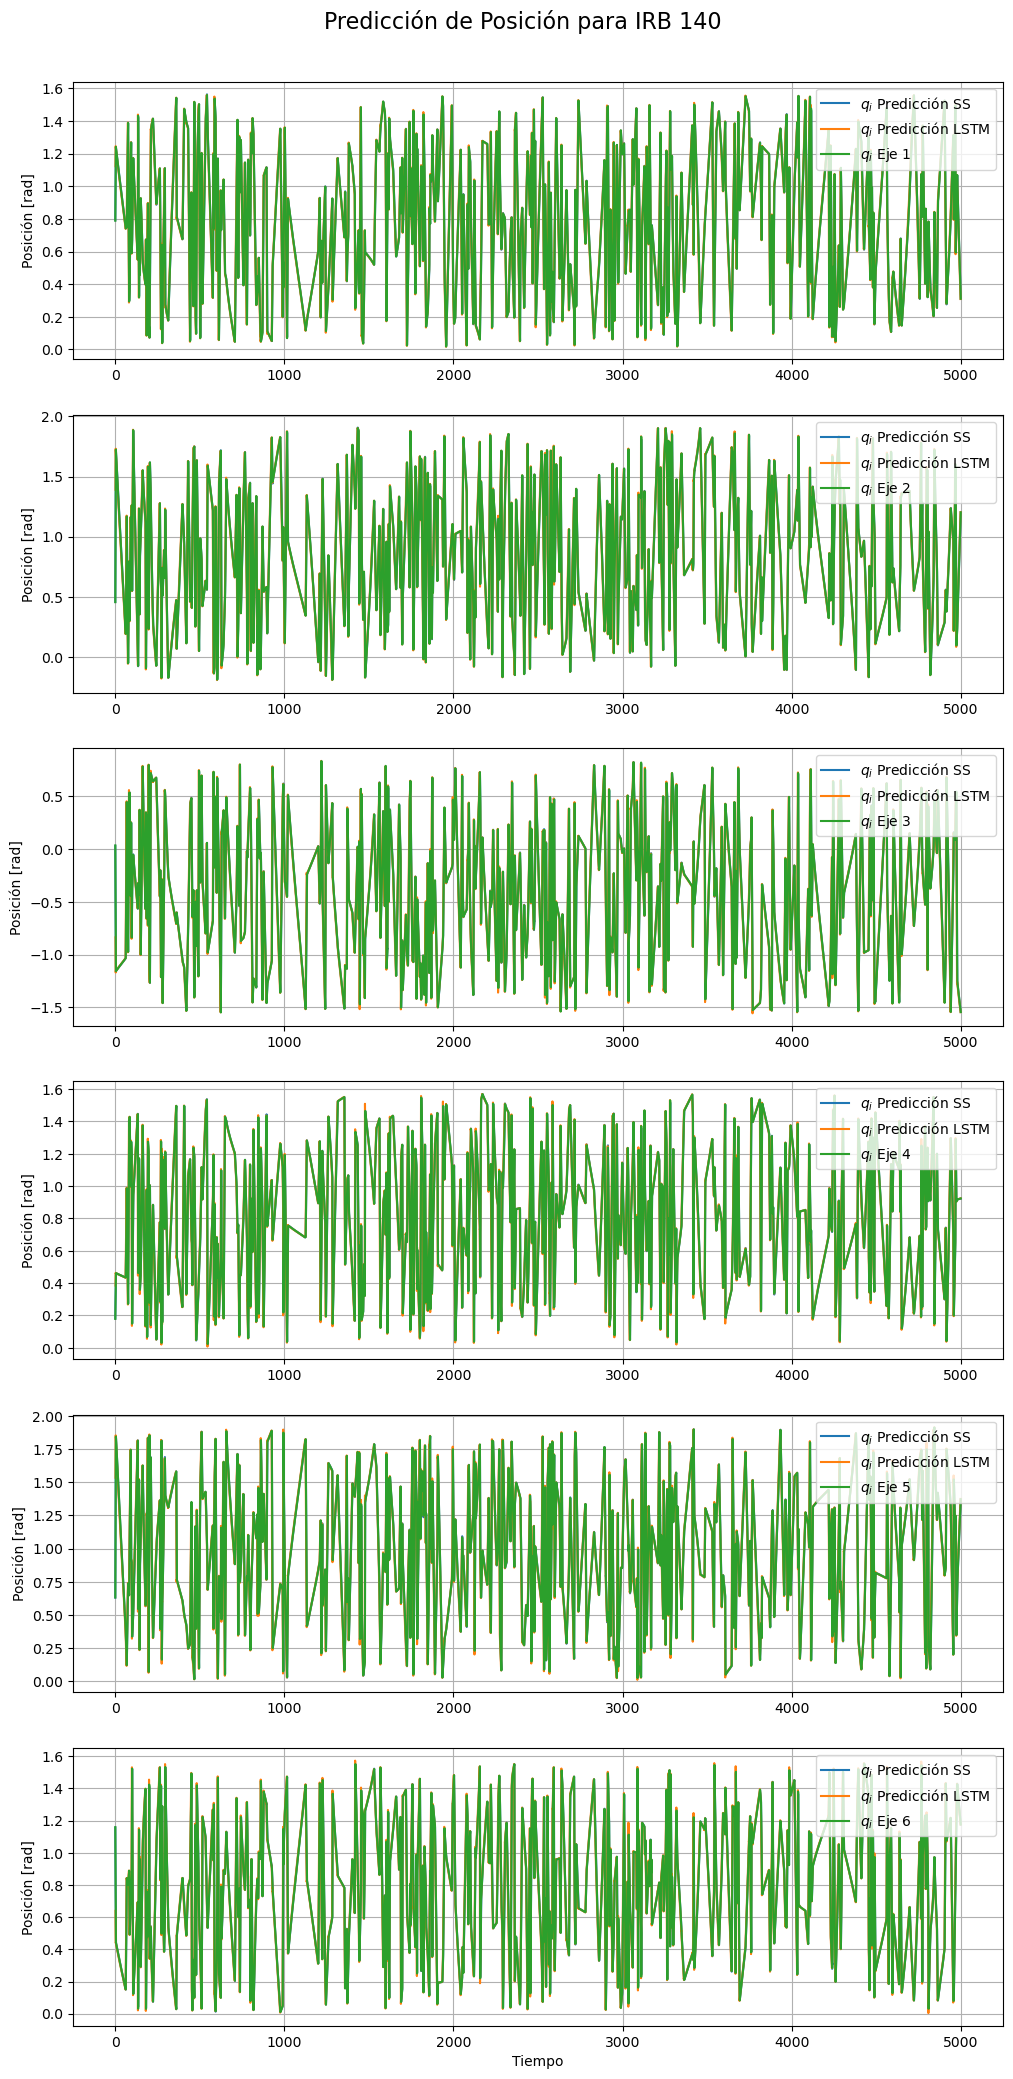

In [ ]:
num_links = 6
t_ref = time_joint
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 24))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Predicción de Posición para IRB 140", fontsize=16, y=0.95)

# Grafico los resultados
for i in range(num_links):
  plt.subplot(num_links, 1, i+1)
  plt.plot(t_ref,q_sim_FF_NN[:,i])
  plt.plot(t_ref_LSTM,q_sim_LSTM[:,i])
  plt.plot(t_ref,outputs_ref[:,i])
  plt.ylabel('Posición [rad]')
  plt.legend([r"$q_{i}$ Predicción SS", r"$q_{i}$ Predicción LSTM", r"$q_{i}$ " f'Eje {i+1}'],loc='upper right', 
             fontsize=10)
  plt.grid(True)

plt.subplots_adjust(top=0.92)  
plt.xlabel('Tiempo');
plt.show()

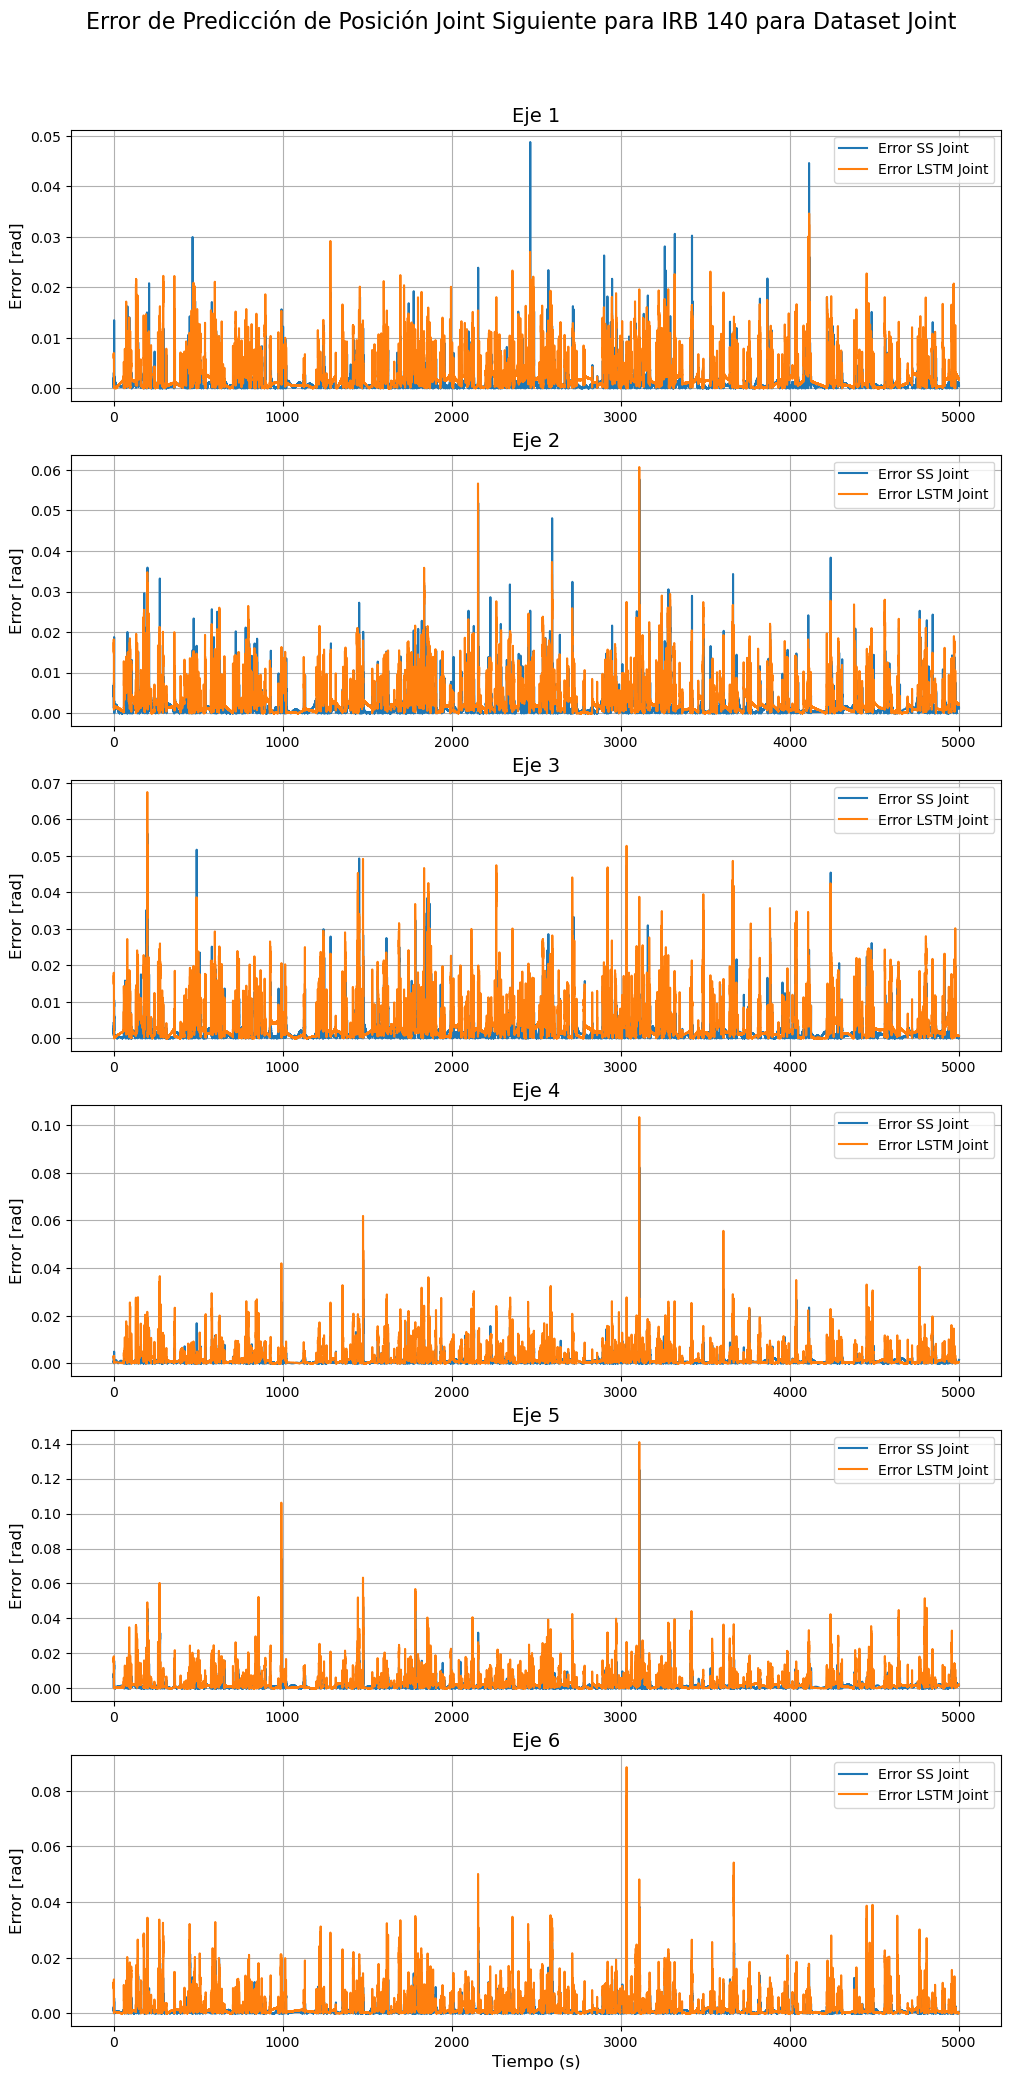

In [ ]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 24))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error de Predicción de Posición Joint Siguiente para IRB 140 para Dataset Joint", 
             fontsize=16,  y=0.95)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)

    error_OSA_Joint_j = np.sqrt((q_sim_FF_NN[:, i] - outputs_ref[:, i])**2)
    error_LSTM_Joint_j = np.sqrt((q_sim_LSTM[:, i] - outputs_ref[w_size-1:, i])**2)
    
    # Graficar los errores
    plt.plot(t_ref, error_OSA_Joint_j, label='Error SS Joint')
    plt.plot(t_ref_LSTM, error_LSTM_Joint_j, label='Error LSTM Joint')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel(r'Error [rad]', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

plt.subplots_adjust(top=0.90)  

# Ajustar los espacios entre subplots
#plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


# **Verificación con Dataset Lineal**

In [ ]:
#Inputs ---> uk=[qTk-1  d_qTk-1  tauTk]T
time_joint_l= times['linear_002_test_10_100_time'][0:-2]

pos_j1_l = j_poses['linear_002_test_10_100_pos_j1'][0:-2] #34440 -> 34438, k-1
pos_j2_l = j_poses['linear_002_test_10_100_pos_j2'][0:-2]
pos_j3_l = j_poses['linear_002_test_10_100_pos_j3'][0:-2]
pos_j4_l = j_poses['linear_002_test_10_100_pos_j4'][0:-2]
pos_j5_l = j_poses['linear_002_test_10_100_pos_j5'][0:-2]
pos_j6_l = j_poses['linear_002_test_10_100_pos_j6'][0:-2]

vels_j1_l = j_vels['linear_002_test_10_100_vel_j1'][0:-2] #34440 -> 34438 k-1
vels_j2_l = j_vels['linear_002_test_10_100_vel_j2'][0:-2]
vels_j3_l = j_vels['linear_002_test_10_100_vel_j3'][0:-2]
vels_j4_l = j_vels['linear_002_test_10_100_vel_j4'][0:-2]
vels_j5_l = j_vels['linear_002_test_10_100_vel_j5'][0:-2]
vels_j6_l = j_vels['linear_002_test_10_100_vel_j6'][0:-2]

torq_j1_l = j_torqs['linear_002_test_10_100_torq_j1'][1:-1] #34440 -> 34438 k
torq_j2_l = j_torqs['linear_002_test_10_100_torq_j2'][1:-1]
torq_j3_l = j_torqs['linear_002_test_10_100_torq_j3'][1:-1]
torq_j4_l = j_torqs['linear_002_test_10_100_torq_j4'][1:-1]
torq_j5_l = j_torqs['linear_002_test_10_100_torq_j5'][1:-1]
torq_j6_l = j_torqs['linear_002_test_10_100_torq_j6'][1:-1]

#Outputs
accs_j1_l = j_accels['linear_002_test_10_100_acc_j1'] #34438 k
accs_j2_l = j_accels['linear_002_test_10_100_acc_j2']
accs_j3_l = j_accels['linear_002_test_10_100_acc_j3']
accs_j4_l = j_accels['linear_002_test_10_100_acc_j4']
accs_j5_l = j_accels['linear_002_test_10_100_acc_j5']
accs_j6_l = j_accels['linear_002_test_10_100_acc_j6']

#Inputs ---> uk=[qTk-1  d_qTk-1  tauTk]T
pos_next_j1_l = j_poses['linear_002_test_10_100_pos_j1'][1:-1] #34440 -> 34438, k-1
pos_next_j2_l = j_poses['linear_002_test_10_100_pos_j2'][1:-1]
pos_next_j3_l = j_poses['linear_002_test_10_100_pos_j3'][1:-1]
pos_next_j4_l = j_poses['linear_002_test_10_100_pos_j4'][1:-1]
pos_next_j5_l = j_poses['linear_002_test_10_100_pos_j5'][1:-1]
pos_next_j6_l = j_poses['linear_002_test_10_100_pos_j6'][1:-1]

In [ ]:
inputs_lin = np.vstack((pos_j1_l, pos_j2_l, pos_j3_l, pos_j4_l, pos_j5_l, pos_j6_l, torq_j1_l, torq_j2_l, torq_j3_l, torq_j4_l, torq_j5_l, torq_j6_l)).T
outputs_lin = np.vstack((pos_next_j1_l,pos_next_j2_l,pos_next_j3_l,pos_next_j4_l,pos_next_j5_l,pos_next_j6_l)).T

In [ ]:
q_sim_FF_NN_L = scaler2_ss.inverse_transform(FF_DD_network.predict(scaler1_ss.transform(inputs_lin)))

X_test_scaled_LSTM_L = scaler1_LSTM.transform(inputs_lin)
X_test_windowed_LSTM_L, t_ref_LSTM_L = create_sequences_with_time(X_test_scaled_LSTM_L, time_joint_l)
q_sim_LSTM_L = scaler2_LSTM.inverse_transform(LSTM_network.predict(X_test_windowed_LSTM_L))

1268/1268 ━━━━━━━━━━━━━━━━━━━━ 1s 559us/step
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


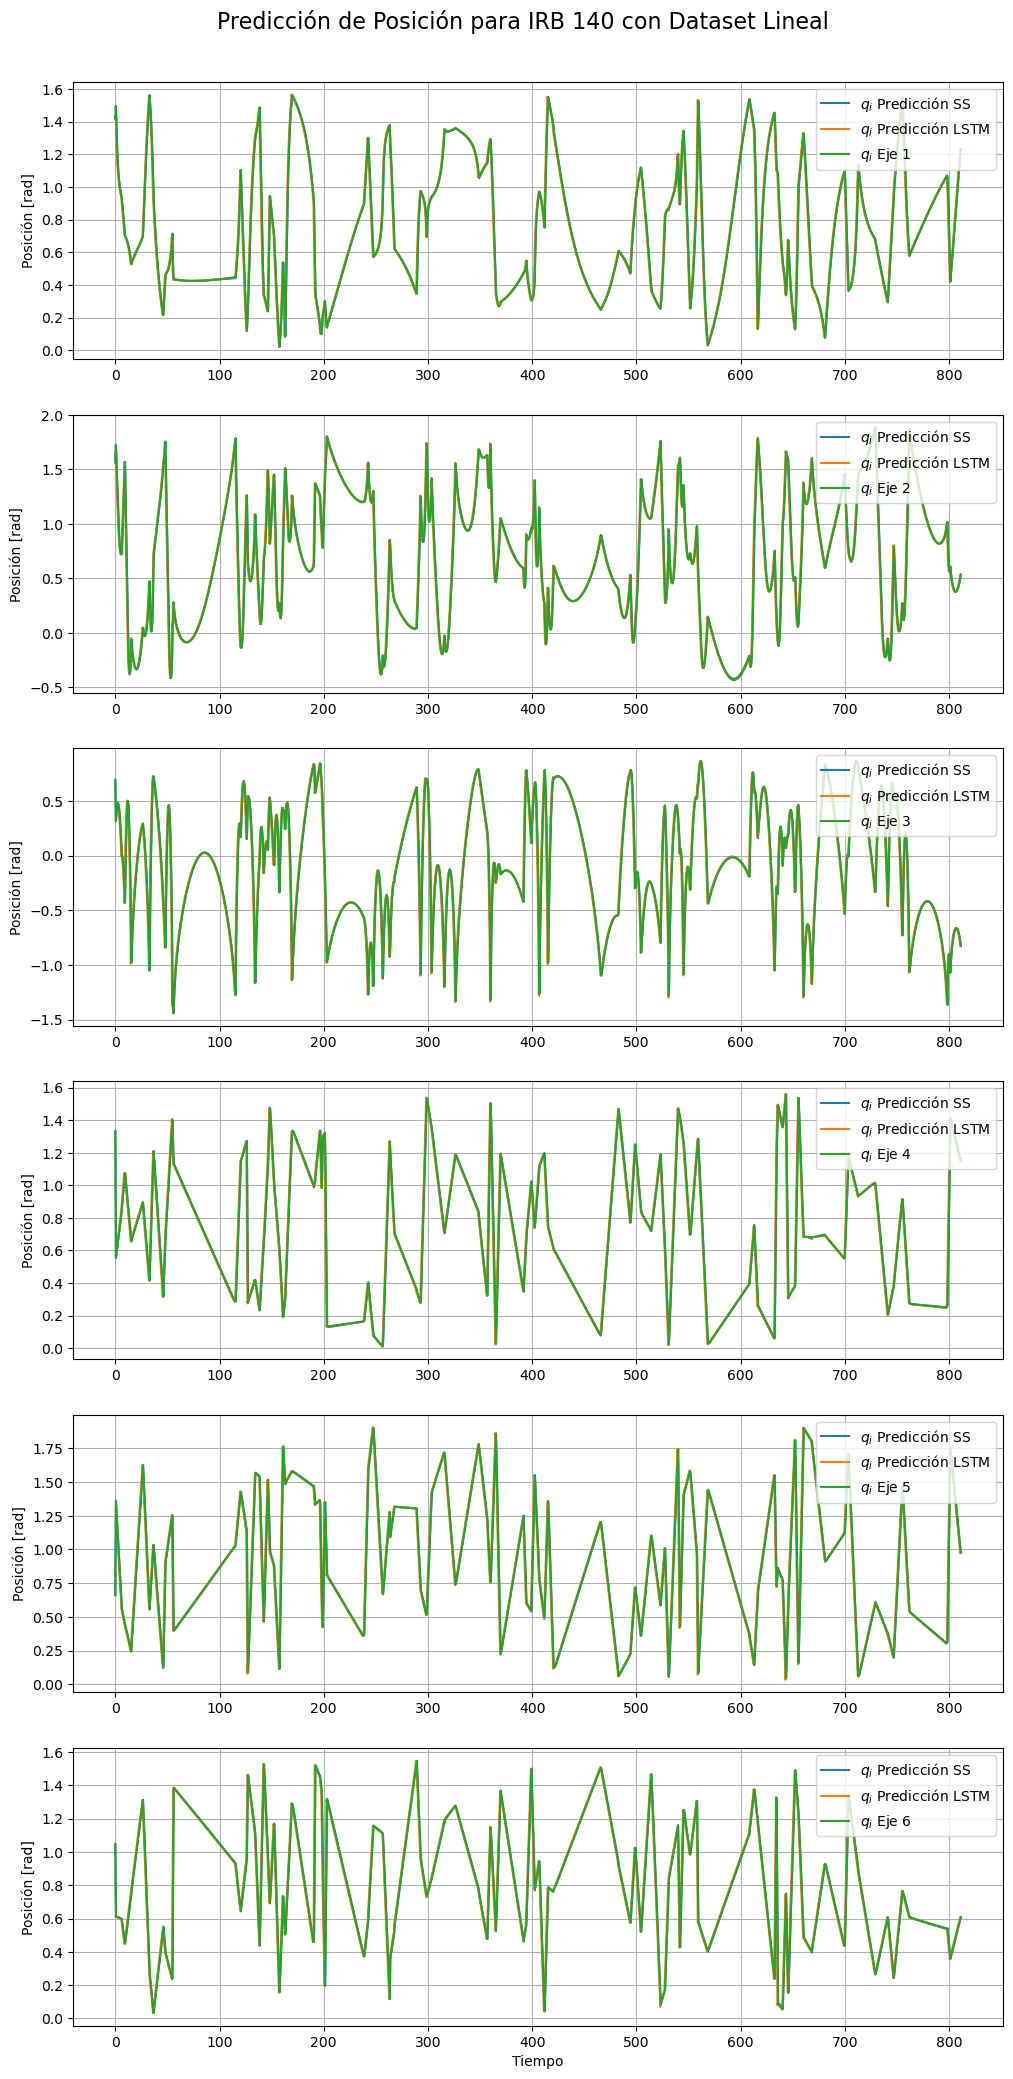

In [ ]:
num_links = 6

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 24))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Predicción de Posición para IRB 140 con Dataset Lineal", fontsize=16, y=0.95)

# Grafico los resultados
for i in range(num_links):
  plt.subplot(num_links, 1, i+1)
  plt.plot(time_joint_l,q_sim_FF_NN_L[:,i])
  plt.plot(t_ref_LSTM_L,q_sim_LSTM_L[:,i])
  plt.plot( time_joint_l,outputs_lin[:,i])
  plt.ylabel('Posición [rad]')
  plt.legend([r"$q_{i}$ Predicción SS", r"$q_{i}$ Predicción LSTM", r"$q_{i}$ " f'Eje {i+1}'],loc='upper right', 
             fontsize=10)
  plt.grid(True)

plt.subplots_adjust(top=0.92)  
plt.xlabel('Tiempo');
plt.show()

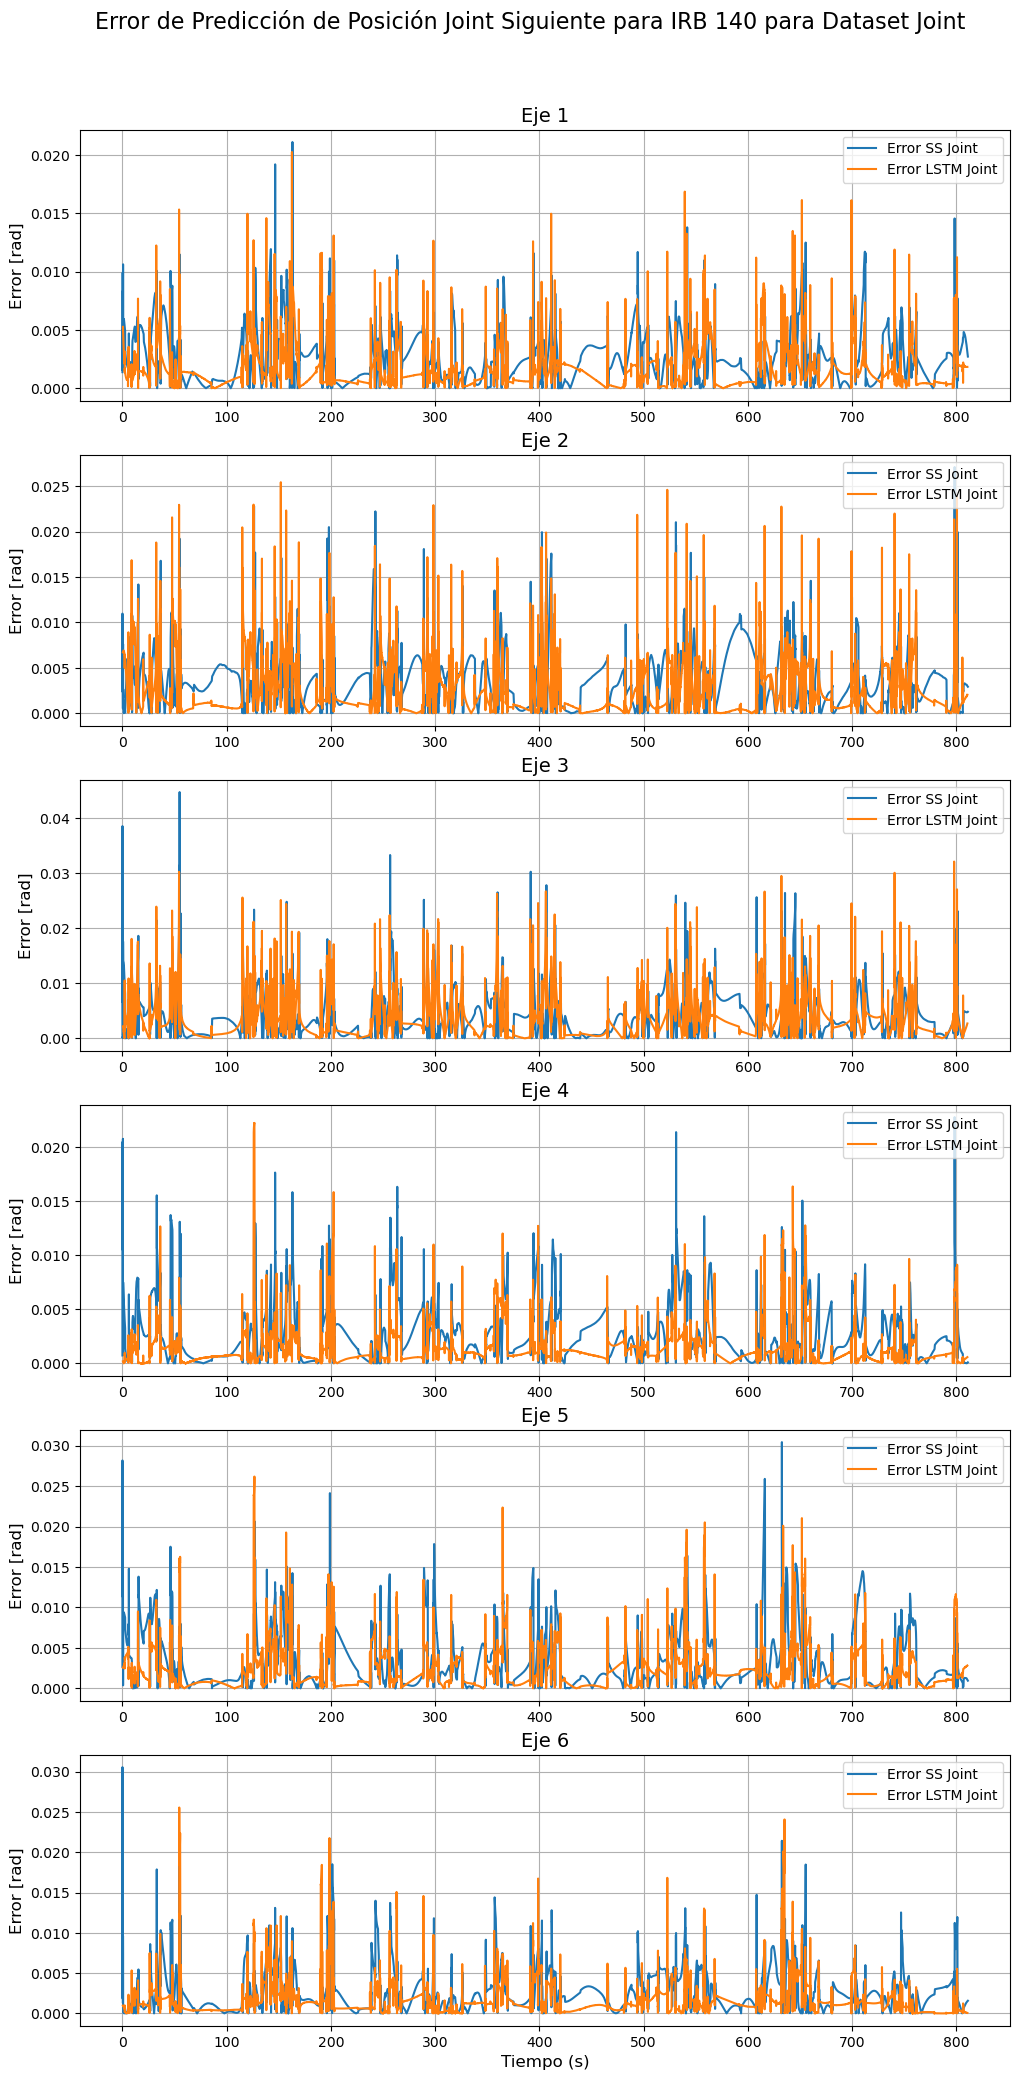

In [ ]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 24))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error de Predicción de Posición Joint Siguiente para IRB 140 para Dataset Joint", 
             fontsize=16,  y=0.95)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)

    error_OSA_Joint_L = np.sqrt((q_sim_FF_NN_L[:, i] - outputs_lin[:, i])**2)
    error_LSTM_Joint_L = np.sqrt((q_sim_LSTM_L[:, i] - outputs_lin[w_size-1:, i])**2)
    
    # Graficar los errores
    plt.plot(time_joint_l, error_OSA_Joint_L, label='Error SS Joint')
    plt.plot(t_ref_LSTM_L, error_LSTM_Joint_L, label='Error LSTM Joint')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel(r'Error [rad]', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

plt.subplots_adjust(top=0.90)  

# Ajustar los espacios entre subplots
#plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


# **Bibliografía y cursos consultados**

*   http://neuralnetworksanddeeplearning.com/
*   [Neural Networks in Python](https://www.superdatascience.com/pages/neural-networks-in-python-materials)
*    [Mint Lab - Awesome robotics datasets](https://github.com/mint-lab/awesome-robotics-datasets)
*    [10 Open-Source Datasets To Learn Robotics](https://analyticsindiamag.com/10-open-source-datasets-to-learn-robotics/)
*    [ARM Labs](https://arm.eecs.umich.edu/), [GIT](https://github.com/UM-ARM-Lab)
*    [Pytorch Kinematics](https://github.com/UM-ARM-Lab/pytorch_kinematics)
*    [BC - Z](https://sites.google.com/view/bc-z/home?pli=1)
*    [Write a file to the controller - ABB Forums](https://forums.robotstudio.com/discussion/8975/write-a-file-to-the-controller)
*    [Importing text file to RAPID - ABB Forums](https://forums.robotstudio.com/discussion/8270/importing-text-file-to-rapid)
*    [Technical reference manual: RAPID Instructions, Functions and Data types - ABB](https://library.e.abb.com/public/b63f78bebabc4b2583fd9bd9a9fb7db7/3HAC065038%20TRM%20RAPID%20RW%207-en.pdf?x-sign=j3CioBZq2yfE9qb7WNe40/iA+mS9SPVwcCVLK3hHaMvmksddjs6K1H5MuBej5lUP)
*    [Function Calling - ABB Forums](https://forums.robotstudio.com/discussion/7487/function-calling)
*    [Short time Acceleration switching - ABB Forums](https://forums.robotstudio.com/discussion/7588/short-time-acceleration-switching)
*    [SoftMax Wiki](https://es.wikipedia.org/wiki/Funci%C3%B3n_SoftMax)
*    [Tensorflow Conceptos](https://www.tensorflow.org/guide/basics?hl=es-419)
*    [ABB IRB 140](https://library.e.abb.com/public/e66aeea30ec47fa4c1257b1300574bc8/140.pdf)
*    [PYRO - For robot dynamic simulation](https://colab.research.google.com/drive/1OILAhXRxM1r5PEB1BWaYtbR147Ff3gr1?usp=sharing#scrollTo=OfiozzVs1Upg), [Git](https://github.com/SherbyRobotics/pyro)